# 0.0. Imports

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as ss
import random

import inflection

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import pickle

from boruta import  BorutaPy

import datetime

import warnings
warnings.filterwarnings('ignore')

### 0.1. Helper Functions

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1) )
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    return np.sqrt((chi2corr / n) / ( min(kcorr - 1, rcorr - 1 )))
    

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

def cross_validation( x_training, k, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, k + 1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation


        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) &(x_training['date'] <= validation_end_date)]
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        # model
        m = model.fit( xtraining, ytraining )
        # prediction
        yhat = m.predict( xvalidation )
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    return pd.DataFrame( {'Model Name': model_name,
                                'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                                'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                                'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

### 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
908669,730,1,2013-04-08,11586,1322,1,1,0,0,c,a,1190.0,9.0,2013.0,0,NaN,NaN,NaN


# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [7]:
old_cols= df1.columns
snakecase = lambda x: inflection.underscore( x )
new_cols = list ( map( snakecase, old_cols))
# rename
df1.columns = new_cols

### 1.2. Data Dimensions

In [8]:
print('Number of rows: ', df1.shape[0])
print('Number of columns: ', df1.shape[1])

Number of rows:  1017209
Number of columns:  18


### 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NA

In [11]:
# competition_distance
print("Max distance: ", df1['competition_distance'].max())
df1['competition_distance'] = df1['competition_distance'].fillna(200000)
print("Max distance: ", df1['competition_distance'].max())

Max distance:  75860.0
Max distance:  200000.0


In [12]:
# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) == True else x['competition_open_since_month'], axis = 1)

In [13]:
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) == True else x['competition_open_since_year'], axis = 1)

In [14]:
# promo2_since_week
print("Distribution of promo 2: \n", df1['promo2'].value_counts())
print("Nan values in promo_2_since_week: ", len(df1['promo2_since_week'][df1['promo2_since_week'].isna() == True]))
print("Stores that didn't have promo 2 and has 'Nan' values in 'promo_2_since_week': ", len(df1[['promo2','promo2_since_week']][(df1['promo2_since_week'].isna() == True) & (df1['promo2'] == 0)]))
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) == True else x['promo2_since_week'], axis = 1)

Distribution of promo 2: 
 1    509178
0    508031
Name: promo2, dtype: int64
Nan values in promo_2_since_week:  508031
Stores that didn't have promo 2 and has 'Nan' values in 'promo_2_since_week':  508031


In [15]:
# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) == True else x['promo2_since_year'], axis = 1)

In [16]:
# promo_interval
months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.apply(lambda x: months[x])
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [17]:
df1.sample(8).T

,156261,717413,184648,467057,999125,60206,194436,404478
store,162,139,674,658,871,1112,427,877
day_of_week,5,4,1,5,4,1,6,6
date,2015-03-13 00:00:00,2013-09-26 00:00:00,2015-02-16 00:00:00,2014-05-09 00:00:00,2013-01-17 00:00:00,2015-06-08 00:00:00,2015-02-07 00:00:00,2014-07-05 00:00:00
sales,6873,6368,0,7267,3577,7878,6350,4824
customers,510,501,0,681,303,722,667,786
open,1,1,0,1,1,1,1,1
promo,0,1,1,1,0,0,0,0
state_holiday,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,0
store_type,d,a,a,d,d,c,a,a


In [18]:
pd.DataFrame([df1.isna().sum(), df1.dtypes]).T

,0,1
store,0,int64
day_of_week,0,int64
date,0,datetime64[ns]
sales,0,int64
customers,0,int64
open,0,int64
promo,0,int64
state_holiday,0,object
school_holiday,0,int64
store_type,0,object


### 1.6. Change Types

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7. Descriptive Statistics

In [20]:
df2 = df1.copy()
num_attributes = df2.select_dtypes(include = ['int32','int64','float64'])
cat_attributes = df2.select_dtypes(exclude = ['int32','int64','float64','datetime64[ns]'])

In [21]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion : std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
stats = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6]).T.reset_index()
stats.columns = ['attributes','mean','median','std','min','max','range','skew','kurtosis']
stats

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

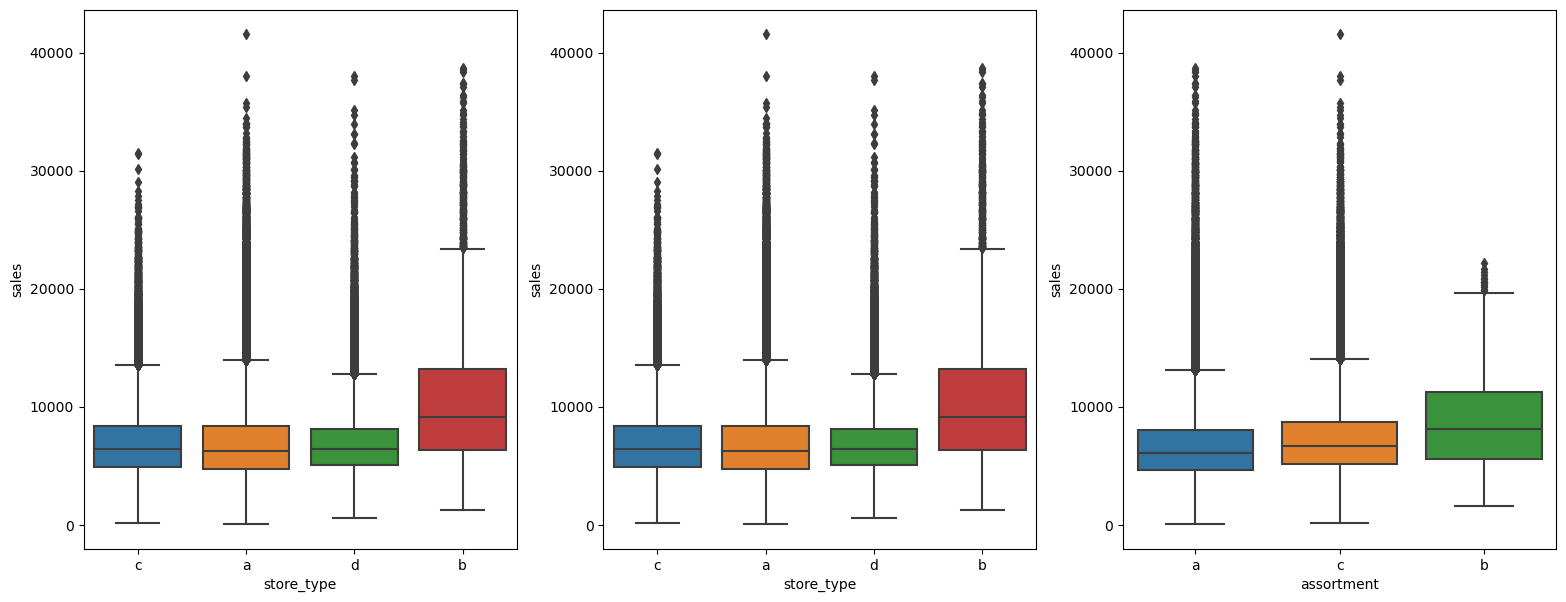

In [23]:
# Size
Figura, Eixo = plt.subplots(figsize=(19, 7))

plt.subplot(1, 3 ,1)
sns.boxplot(x = 'store_type',y = 'sales', data = df2[(df2['sales'] != 0) & (df2['store_type'] != '0')])
plt.subplot (1, 3, 2)
sns.boxplot(x = 'store_type',y = 'sales', data = df2[df2['sales'] != 0])
plt.subplot (1, 3, 3)
sns.boxplot(x = 'assortment',y = 'sales', data = df2[df2['sales'] != 0])

# 2.0. Feature Engineering

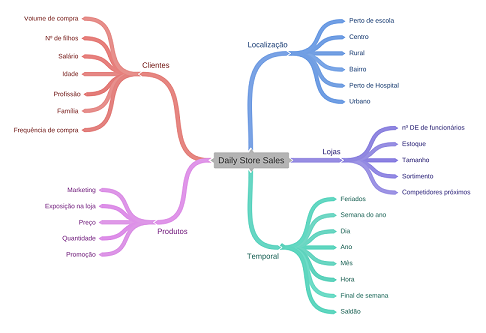

In [24]:
df3 = df2.copy()
Image('Img\mind_map_hypotesis.png', width = 800, height = 500)

### 2.1. Hypotesis

#### 2.2.1. Hypotesis: store

- Stores with more employees should sell more

- Stores with larger inventory should sell more

- Bigger stores should sell more

- Smaller stores should sell less

- Stores with greater assortment should sell more

- Stores with closer competitors should sell less

- Stores with further competitors should sell more

#### 2.2.2. Hypotesis: product

- Stores that invest more in marketing should sell more

- Stores that display more products in the window should sell more

- Stores that have lower prices should sell more

- Stores that have lower prices for longer should sell more

- Stores with longer active promotions should sell more

- Stores with more days of promotion should sell more

- Stores with more consecutive promotions should sell more

#### 2.2.3. Hypotesis: Time

- Stores with longer competitors should sell more

- Stores that open on Christmas should sell more

- Stores should sell more over the years

- Stores should sell more in the second half of the year

- Stores should sell more after the 10th of each month

- Stores should sell less on weekends

- Stores should sell less during school holidays

### 2.2. Final Hypotesis list

- Stores with greater assortment should sell more

- Stores with closer competitors should sell less

- Stores with longer competitors should sell more

- Stores with longer active promotions should sell more

- Stores with more days of promotion should sell more

- Stores with more consecutive promotions should sell more

- Stores that open on Christmas should sell more

- Stores should sell more over the years

- Stores should sell more in the second half of the year

- Stores should sell more after the 10th of each month

- Stores should sell less on weekends

- Stores should sell less during school holidays

### 2.3. Feature Engineering

In [25]:
df3 = df2.copy()
# year
df3['year'] = df3['date'].dt.year
# month
df3['month'] = df3['date'].dt.month
# day
df3['day'] = df3['date'].dt.day
# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear
# year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

# competition since
df3['competition_since'] = df3.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df3['competition_time_month'] = ((df3['date'] - df3['competition_since']) / 30).apply(lambda x: x.days).astype(int)
# promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df3['promo_time_week'] = ((df3['date'] - df3['promo_since']) / 7).apply(lambda x: x.days).astype(int)
# assortment
dict_assort = {'a': 'basic', 'b': 'extra','c': 'extended'}
df3['assortment'] = df3['assortment'].apply(lambda x: dict_assort[x])
# state holiday
dict_holiday = {'0': 'regular_day', 'a':'public_holiday','b': 'easter','c': 'christmas'}
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: dict_holiday[x])

In [26]:
df3.sample(5).T

,967117,625158,462126,317026,592755
store,83,429,187,291,361
day_of_week,4,3,2,1,4
date,2013-02-14 00:00:00,2013-12-18 00:00:00,2014-05-13 00:00:00,2014-10-06 00:00:00,2014-01-16 00:00:00
sales,3464,9134,5379,11730,4387
customers,350,609,761,1155,520
open,1,1,1,1,1
promo,0,1,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,a,d,a,d,c


# 3.0. Data Filtering

In [27]:
df4 = df3.copy()

### 3.1. Line Filtering

In [28]:
df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]

### 3.2 Feature Selection

In [29]:
cols_drop = ["customers","open","promo_interval","month_map"]
df4 =df4.drop(cols_drop, axis = 1)

# 4.0. Exploratory Data Analysis

In [30]:
df5 = df4.copy()

### 4.1. Univariate Analysis

#### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales'>

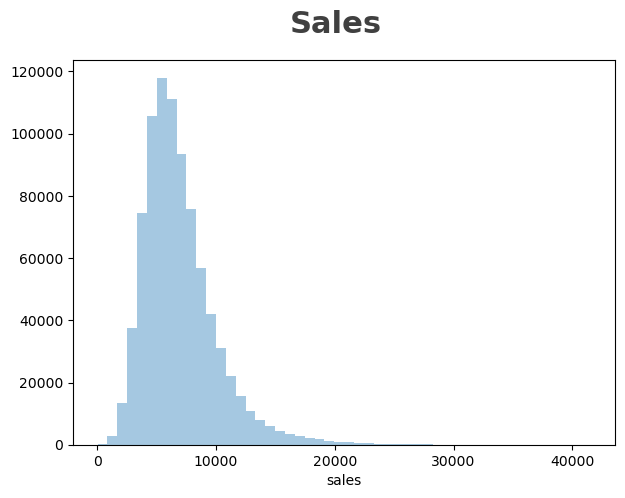

In [31]:
Fig, axis = plt.subplots(figsize=(7, 5))
plt.suptitle('Sales', fontsize=22, color='#404040', fontweight=600)
sns.distplot(df4['sales'], kde = False)

#### 4.1.2. Numerical Variables

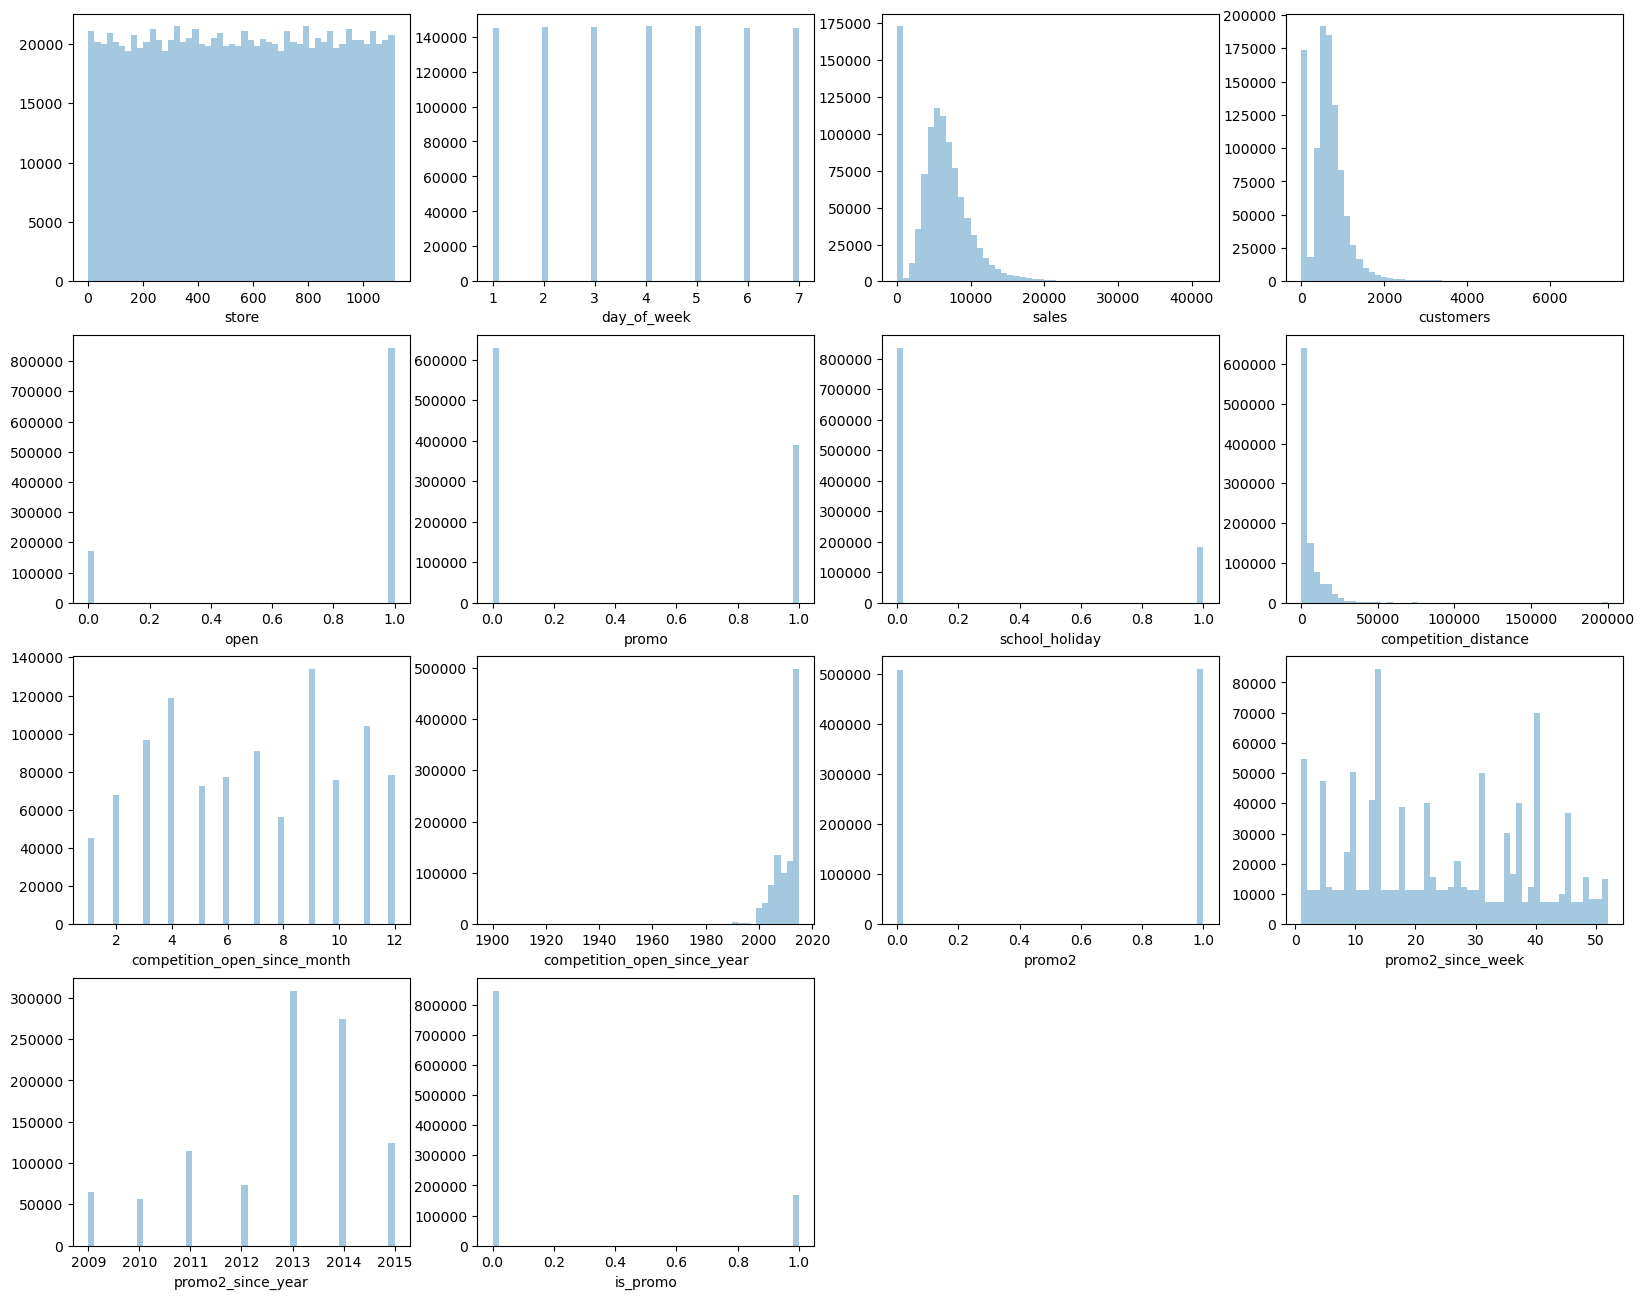

In [32]:
plt.rcParams["figure.figsize"] = (20,16)
for i in range(len(num_attributes.columns)):
    cols = num_attributes.columns
    plt.subplot(4, 4, i+1)
    sns.distplot(num_attributes[cols[i]], kde = False)

#### 4.1.3.Categorical Variables

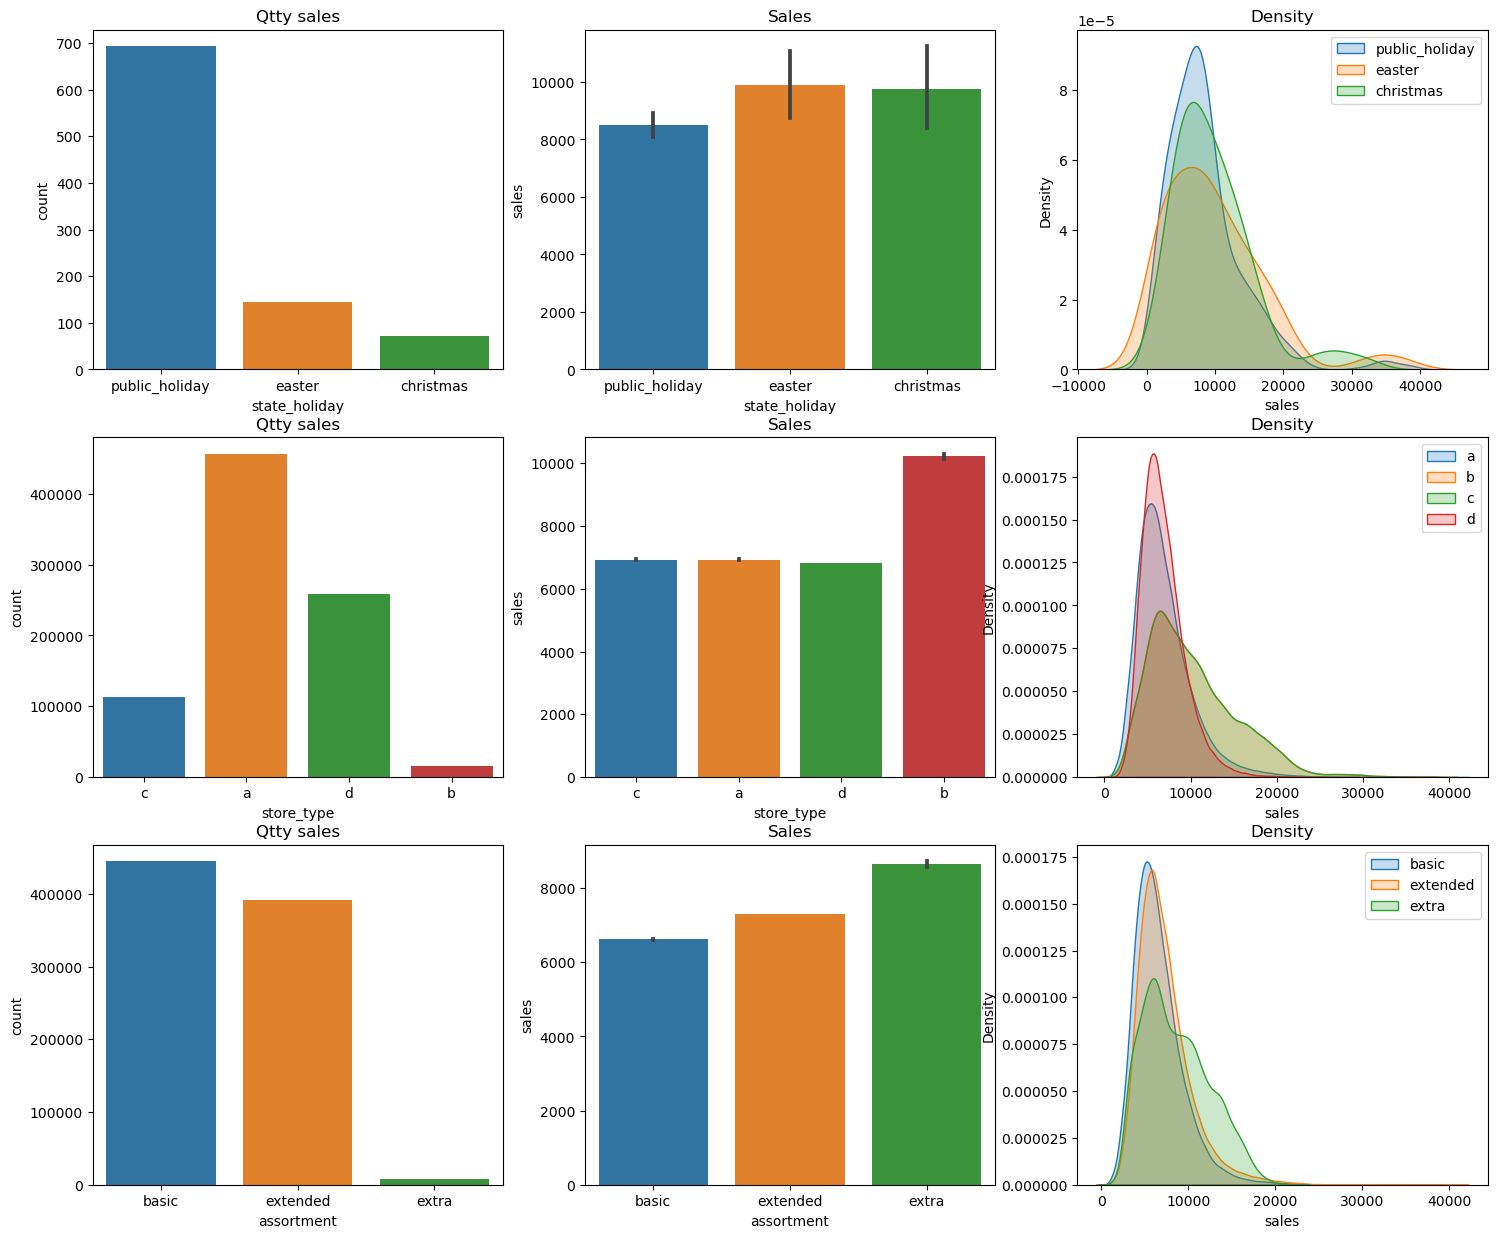

In [33]:
plt.rcParams["figure.figsize"] = (18,15)
plt.subplot(3, 3, 1)
plt.title('Qtty sales')
sns.countplot(x = df5['state_holiday'][df5['state_holiday'] != 'regular_day'] )
plt.subplot(3, 3, 2)
plt.title('Sales')
sns.barplot(x = df5['state_holiday'][df5['state_holiday'] != 'regular_day'] , y = df5['sales'])
plt.subplot(3, 3, 3)
plt.title('Density')
sns.kdeplot(x = df5['sales'][df5['state_holiday'] == 'public_holiday'] , label = 'public_holiday', shade = True)
sns.kdeplot(x = df5['sales'][df5['state_holiday'] == 'easter'] , label = 'easter', shade = True)
sns.kdeplot(x = df5['sales'][df5['state_holiday'] == 'christmas'] , label = 'christmas', shade = True)
plt.legend(labels = ['public_holiday','easter','christmas'],loc = 'upper right')


plt.subplot(3, 3, 4)
plt.title('Qtty sales')
sns.countplot(x = df5['store_type'] )
plt.subplot(3, 3, 5)
plt.title('Sales')
sns.barplot(x = df5['store_type'] , y = df5['sales'])
plt.subplot(3, 3, 6)
plt.title('Density')
sns.kdeplot(x = df5['sales'][df5['store_type'] == 'a'] , label = 'a', shade = True)
sns.kdeplot(x = df5['sales'][df5['store_type'] == 'b'] , label = 'b', shade = True)
sns.kdeplot(x = df5['sales'][df5['store_type'] == 'b'] , label = 'c', shade = True)
sns.kdeplot(x = df5['sales'][df5['store_type'] == 'd'] , label = 'd', shade = True)
plt.legend(labels = ['a','b','c','d'],loc = 'upper right')

plt.subplot(3, 3, 7)
plt.title('Qtty sales')
sns.countplot(x = df5['assortment'] )
plt.subplot(3, 3, 8)
plt.title('Sales')
sns.barplot(x = df5['assortment'] , y = df5['sales'])
plt.subplot(3, 3, 9)
plt.title('Density')
sns.kdeplot(x = df5['sales'][df5['assortment'] == 'basic'] , label = 'basic', shade = True)
sns.kdeplot(x = df5['sales'][df5['assortment'] == 'extended'] , label = 'extended', shade = True)
sns.kdeplot(x = df5['sales'][df5['assortment'] == 'extra'] , label = 'extra', shade = True)
plt.legend(labels = ['basic','extended','extra'],loc = 'upper right')



### 4.2. Bivariate Analysis

- **Hypotesis 1:** Stores with greater assortment should sell more\
**True** : Stores with greater assortment (extended e extra) have a higher average turnover

<AxesSubplot:title={'center':'Sales by assortment'}, xlabel='year_week'>

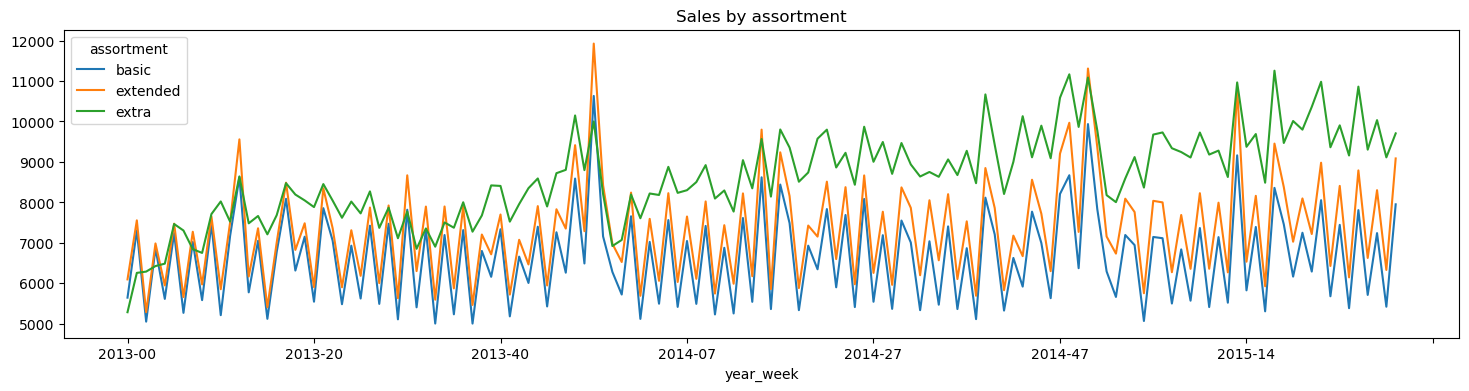

In [34]:
assort_sales = df5[['assortment','sales','date']].groupby('assortment').agg({'sales':'sum', 'date': 'count'}).reset_index().rename(columns={'date':'count'})
plt.rcParams["figure.figsize"] = (18,4)

assort_sales_2 = df5[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
assort_sales_2 = assort_sales_2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
assort_sales_2.plot(title = 'Sales by assortment')

In [35]:
assort_sales['avg_sales'] = assort_sales['sales']/assort_sales['count']
assort_sales

,assortment,sales,count,avg_sales
0,basic,2945750070,444875,6621.523057
1,extended,2856484241,391254,7300.843547
2,extra,70946312,8209,8642.503594


-  **Hypotesis 2:**  Stores with closer competitors should sell less\
**FALSE** : Sales are not impacted by the distance of the competitors.

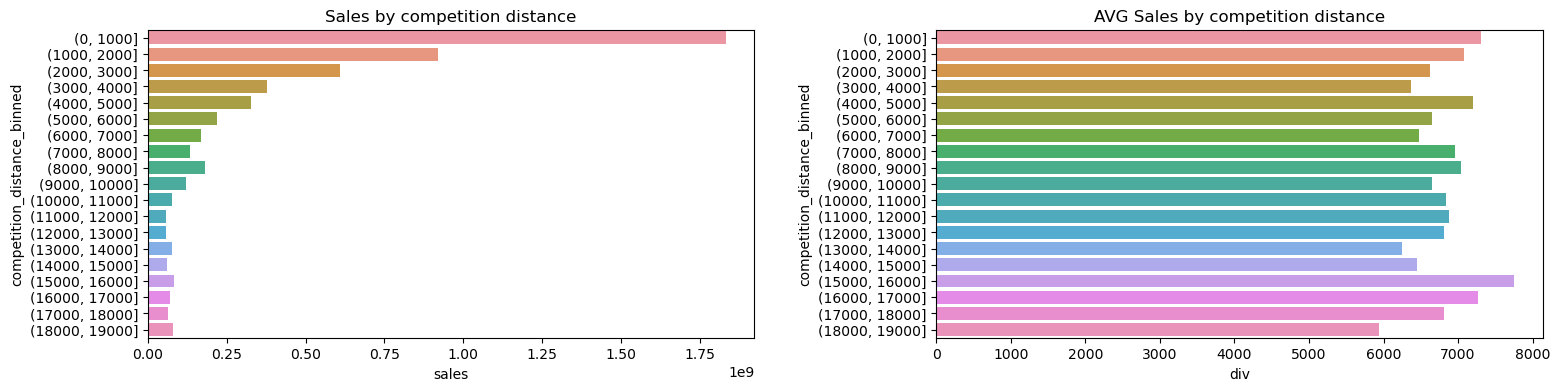

In [36]:
plt.rcParams["figure.figsize"] = (18,4)
plt.subplot(1, 2, 1)
comp_dist = df5[['store','competition_distance','sales']]
bins = list(np.arange(0,20000, 1000))
comp_dist['competition_distance_binned'] = pd.cut(comp_dist['competition_distance'], bins = bins)
comp_dist_2 = comp_dist.groupby('competition_distance_binned').sum().reset_index()

plt.title ('Sales by competition distance')
sns.barplot(y = 'competition_distance_binned', x = 'sales', data = comp_dist_2)
plt.subplot(1, 2, 2)
comp_dist_3 = comp_dist.groupby('competition_distance_binned').agg({'competition_distance':'count', 'sales': 'sum'}).reset_index()
comp_dist_3['div'] = comp_dist_3['sales'] / comp_dist_3['competition_distance']
plt.title ('AVG Sales by competition distance')
sns.barplot(y = 'competition_distance_binned', x = 'div', data = comp_dist_3)
plt.subplots_adjust(wspace=0.3)

<AxesSubplot:title={'center':'Competition distance vs Sales - scatterplot'}, xlabel='competition_distance', ylabel='sales'>

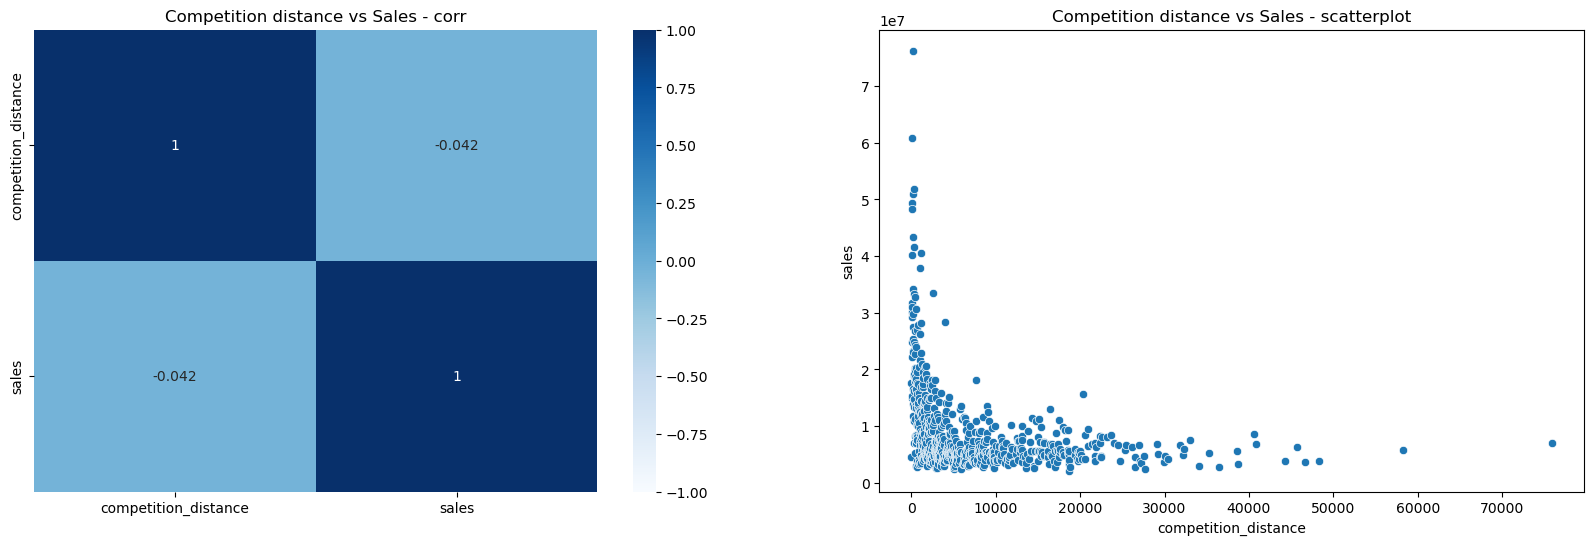

In [37]:
plt.rcParams["figure.figsize"] = (20,6)
plt.subplot(1, 2, 1)
plt.title ('Competition distance vs Sales - corr')
sns.heatmap(comp_dist[['competition_distance','sales']].corr(method = 'pearson'), annot = True, cmap = 'Blues', vmin = -1, vmax = 1)
plt.subplot(1, 2, 2)
comp_dist = comp_dist.groupby('competition_distance').sum().reset_index()
plt.title ('Competition distance vs Sales - scatterplot')
sns.scatterplot(x = comp_dist['competition_distance'][comp_dist['competition_distance']<200000], y = comp_dist['sales'], data = comp_dist)


- **Hypotesis 3:**  Stores with longer competitors should sell more \
**FALSE** : The longer the competition time, the lower the revenue

<AxesSubplot:title={'center':'Sales x Competition time (month)'}, xlabel='competition_time_month', ylabel='sales'>

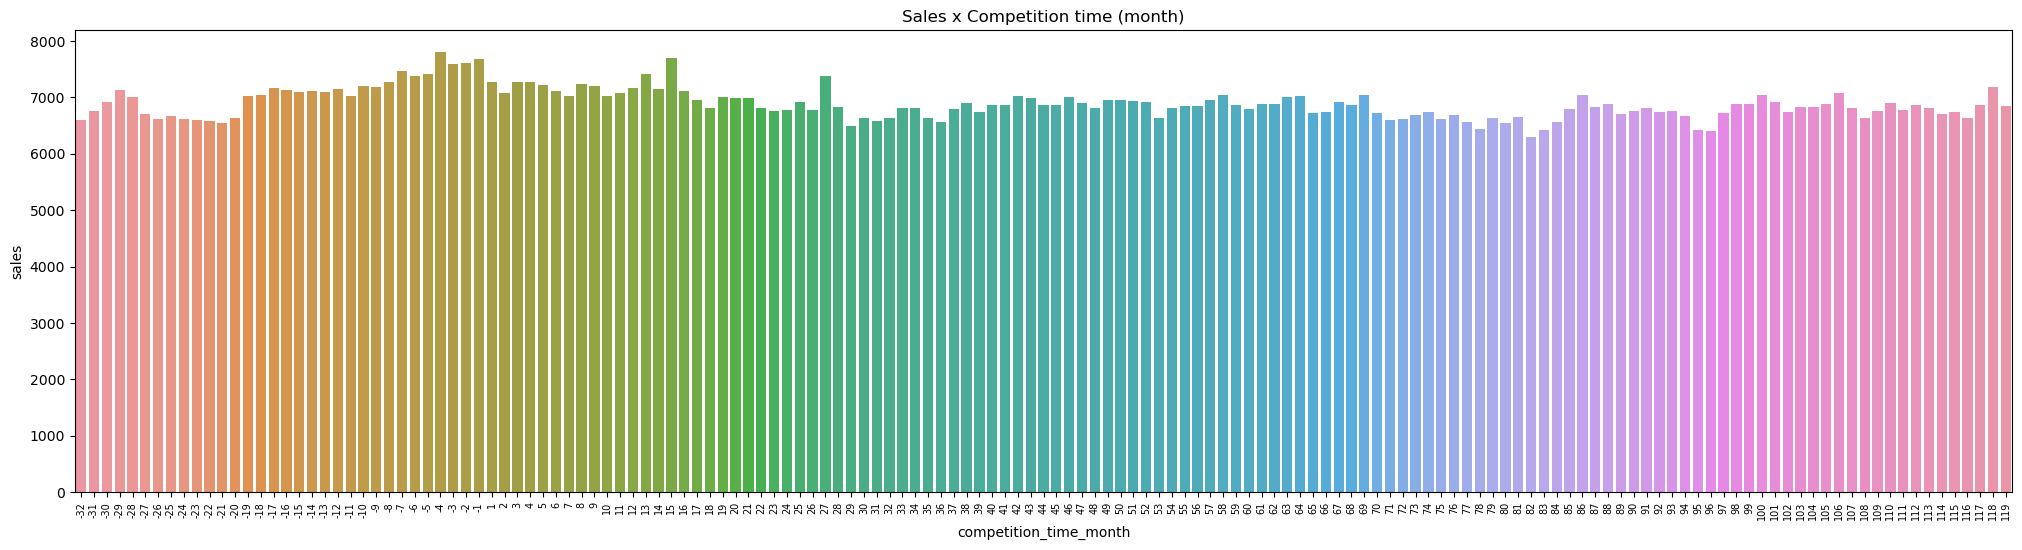

In [38]:
plt.rcParams["figure.figsize"] = (25,6)
plt.title("Sales x Competition time (month)")
competition_since = df5[['competition_time_month','sales','year']]
competition_since = competition_since[competition_since['year'] != 2015]
competition_since = competition_since[(competition_since['competition_time_month'] < 120) & (competition_since['competition_time_month'] != 0)]
competition_since = competition_since.groupby('competition_time_month').mean().reset_index()
plt.xticks(fontsize = 7, rotation = 90)
sns.barplot(x = 'competition_time_month', y = 'sales', data = competition_since)

<AxesSubplot:title={'center':'Correlation'}>

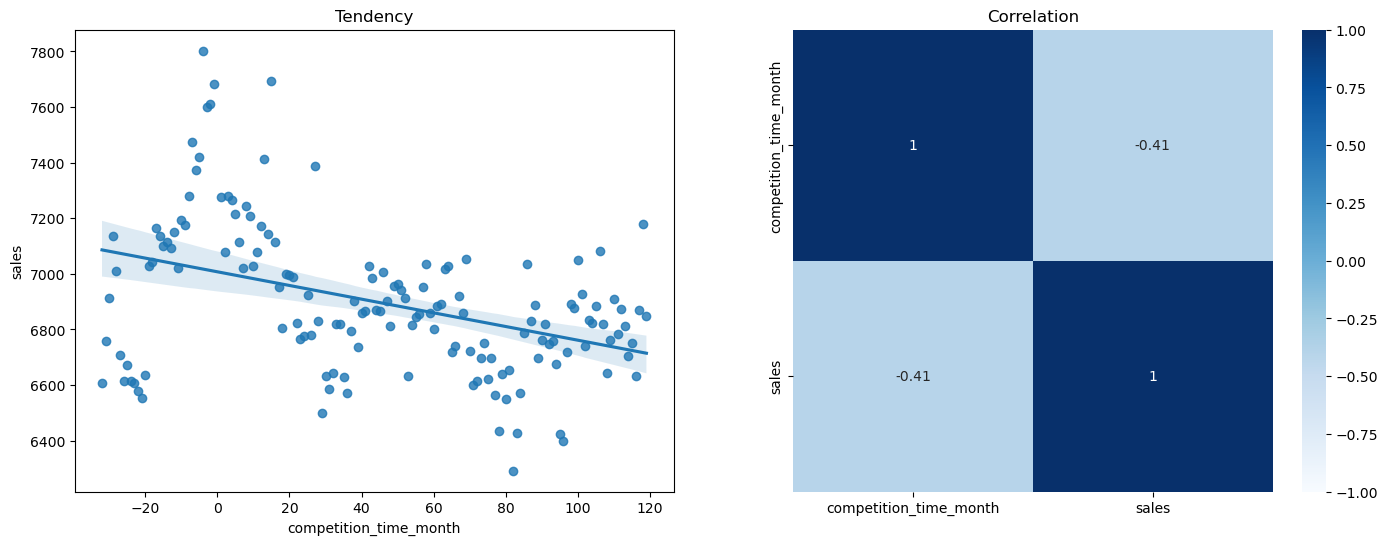

In [39]:
plt.rcParams["figure.figsize"] = (17,6)
plt.subplot(1, 2, 1)
plt.title("Tendency")
sns.regplot(x = 'competition_time_month', y = 'sales', data = competition_since)

plt.subplot(1, 2, 2)
plt.title("Correlation")
sns.heatmap(competition_since[['competition_time_month','sales']].corr(method = 'pearson'), annot = True,cmap = 'Blues', vmin = -1, vmax = 1 )


-  **Hypotesis 4:** Stores with more days of promotion should sell more\
**FALSE** : Variations were identified due to randomness of the data, so it is not possible to confirm this statement

<AxesSubplot:title={'center':'Tendency'}, xlabel='percentage', ylabel='sales'>

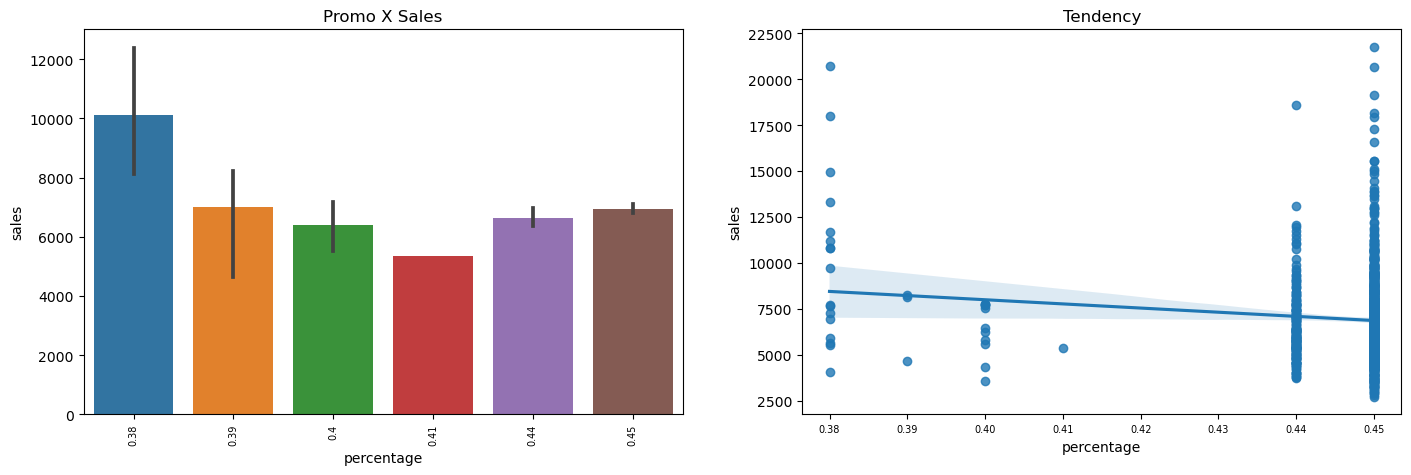

In [40]:
plt.rcParams["figure.figsize"] = (17,5)
plt.subplot(1, 2, 1)
plt.xticks(fontsize=7,rotation = 90)
plt.title("Promo X Sales")
promo = df5[['store','promo','sales','date']].groupby('store').agg({'sales':'mean', 'date': 'count','promo':'sum'}).reset_index().rename(columns={'date':'days','promo':'days_of_promo'})
promo['percentage'] = (promo['days_of_promo'] / promo['days']).round(2)

sns.barplot(x = 'percentage', y = 'sales', data = promo)

plt.subplot(1, 2, 2)
plt.title("Tendency")
plt.xticks(fontsize=7)
sns.regplot(x = 'percentage', y = 'sales', data = promo)

- **Hypotesis 5:** Stores with longer active promotions should sell more\
**FALSE** Stores with longer active promotions sell less after a certain period of promotion

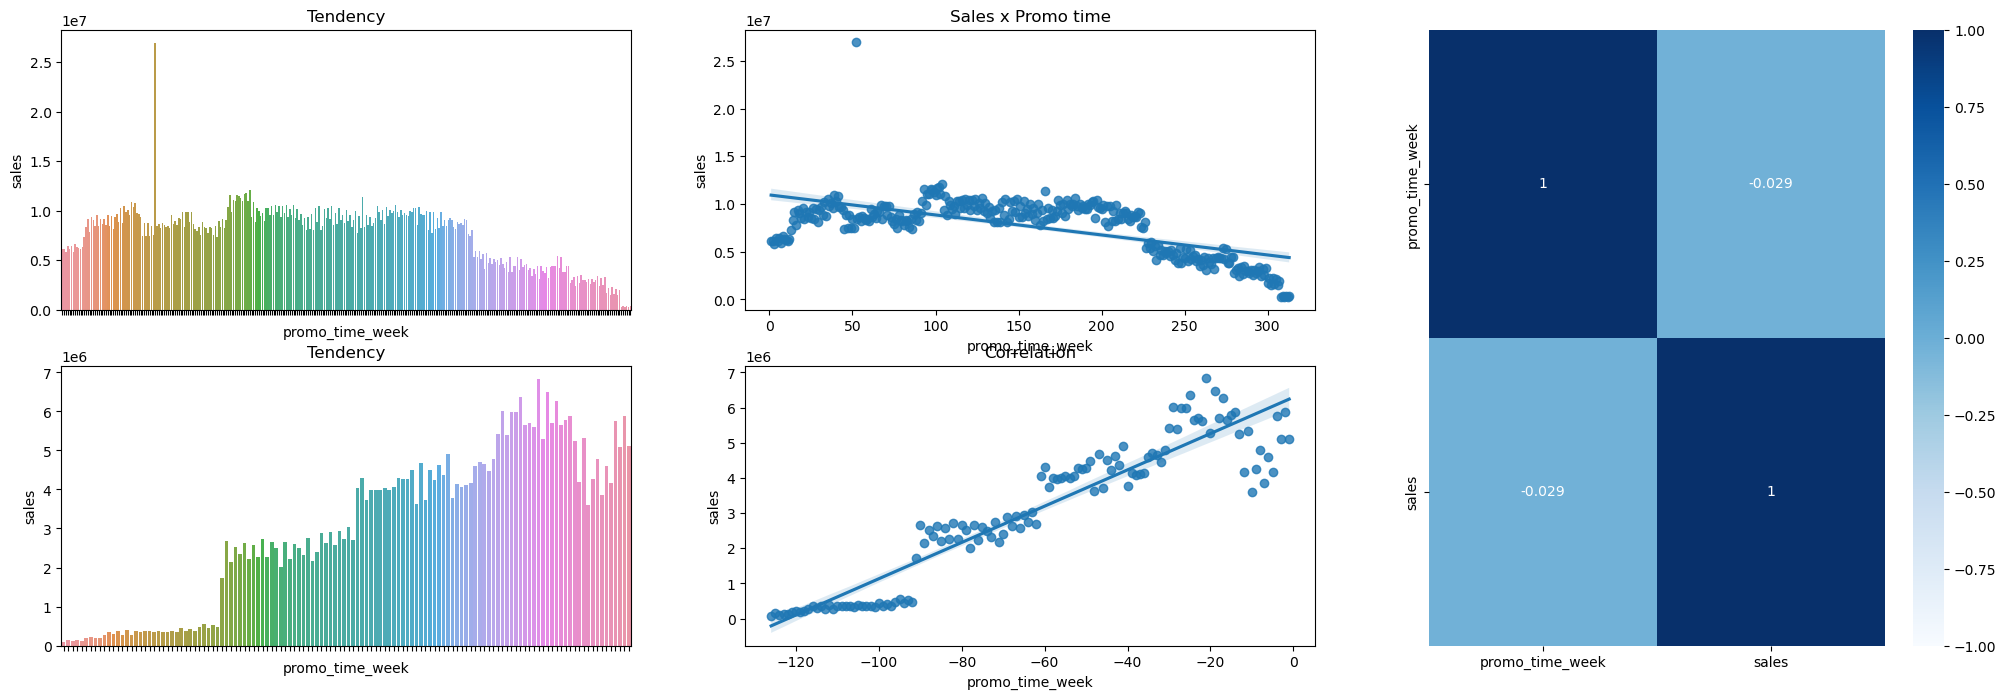

In [41]:
plt.rcParams["figure.figsize"] = (25,8)
time_promo = df5[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = matplotlib.gridspec.GridSpec( 2, 3 )
plt.title("Sales x Promo time")
plt.subplot( grid[0,0] )
time_promo_2 = time_promo[time_promo['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=time_promo_2 ).set(xticklabels=[]);

plt.title("Tendency")
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=time_promo_2 );

plt.title("Sales x Promo time")
plt.subplot( grid[1,0] )
time_promo_3 = time_promo[time_promo['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=time_promo_3 ).set(xticklabels=[]);

plt.title("Tendency")
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=time_promo_3 );

plt.title("Correlation")
plt.subplot( grid[:,2] )
sns.heatmap( time_promo.corr( method='pearson' ), annot=True, cmap = 'Blues', vmin = -1, vmax = 1 );

-  **Hypotesis 6:** Stores with more consecutive promotions should sell more\
**FALSE** Stores with more consecutive promotions sell less

In [42]:
df5[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


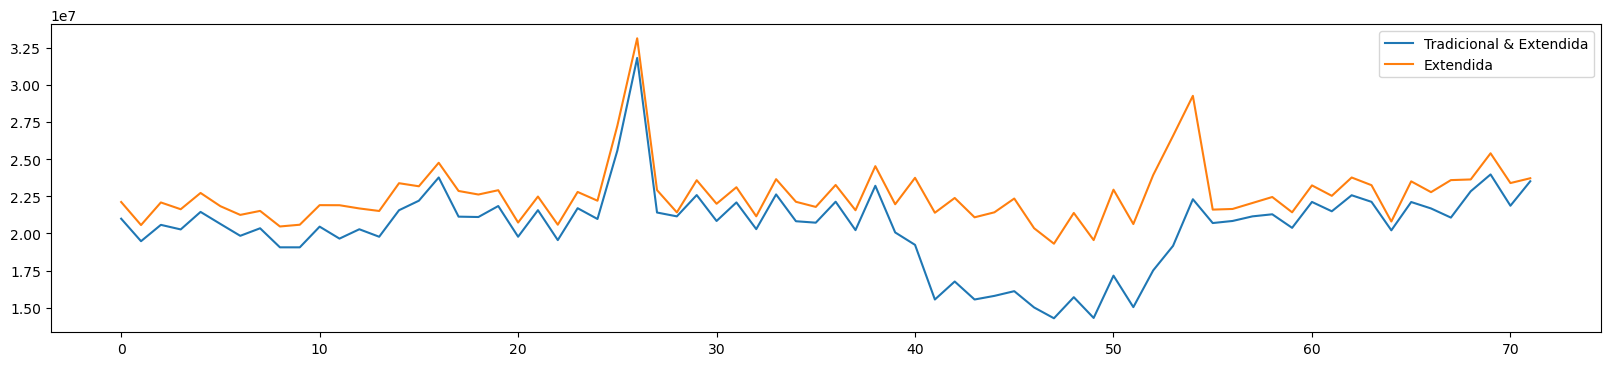

In [43]:
plt.rcParams["figure.figsize"] = (20,4)

promos = df5[( df5['promo'] == 1 ) & ( df5['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = promos.plot()

promos_1 = df5[( df5['promo'] == 1 ) & ( df5['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
promos_1.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

  **Hypotesis 7:** - Stores that open on Christmas should sell more\
**TRUE** Stores that opened on 12/25 and 12/26 in the years 2013 and 214 have higher sales than stores that only opened on 12/26 and the stores that did not open on Christmas holidays.
  

<AxesSubplot:title={'center':'Sales x holiday'}, xlabel='year', ylabel='avg_sales'>

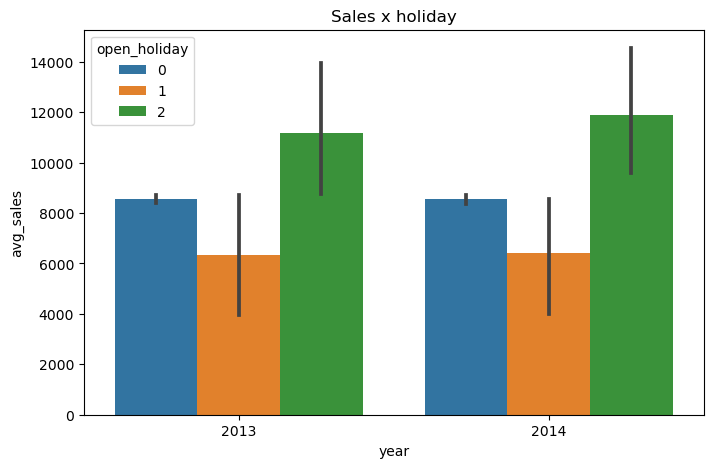

In [44]:
plt.rcParams["figure.figsize"] = (8,5)
plt.title('Sales x holiday')
stores_christmas = df5[['store','date','state_holiday','year','month','sales']][df5['month'] == 12]
stores_christmas['state_holiday'] = stores_christmas['state_holiday'].apply(lambda x: 1 if x=='christmas' else 0)
stores_christmas_grouped = stores_christmas.groupby(['store','year']).agg(    open_holiday = ('state_holiday', 'sum'), month = ('month','mean'), avg_sales = ('sales','mean') ).reset_index()
sns.barplot(x = 'year', y = 'avg_sales', hue = 'open_holiday', data = stores_christmas_grouped )

**Hypotesis 8:**  Stores should sell more over the years\
**TRUE** There is a trend of increasing sales over the years

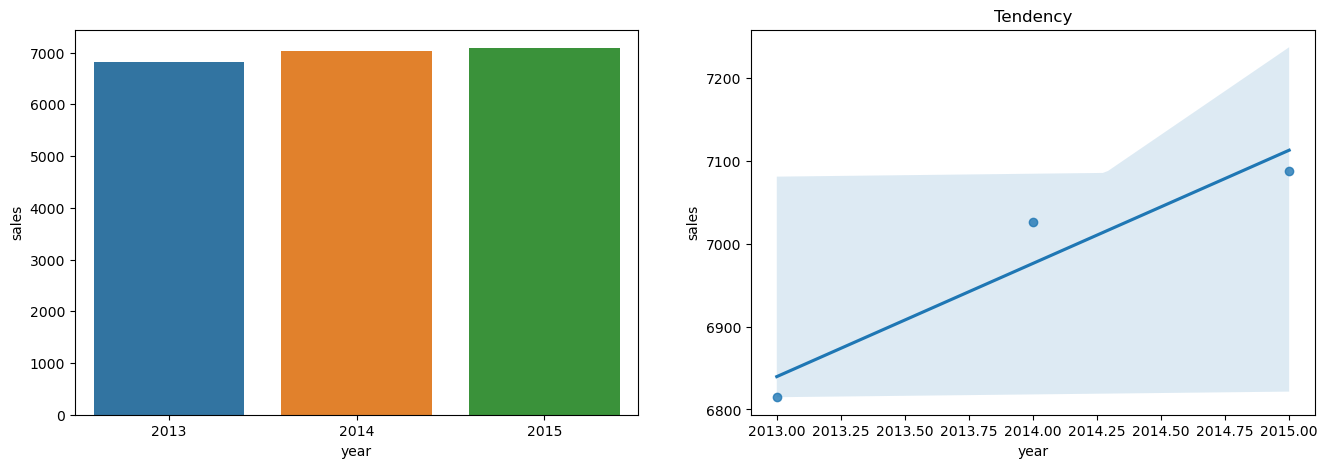

In [45]:
plt.rcParams["figure.figsize"] = (16,5)
plt.title('Sales x year')
time_years = df5[['year', 'sales']].groupby( 'year' ).mean().reset_index()
plt.subplot( 1, 2, 1 )
sns.barplot( x='year', y='sales', data=time_years );
plt.subplot( 1, 2, 2 )
plt.title('Tendency')
sns.regplot( x='year', y='sales', data=time_years );

**Hypotesis 9:**  Stores should sell more in the second half of the year\
**TRUE** There is a slight increase in sales in the second half. Analyzing the monthly chart, we can see that this is due to December sales

<AxesSubplot:title={'center':'Sales x month'}, xlabel='month', ylabel='sales'>

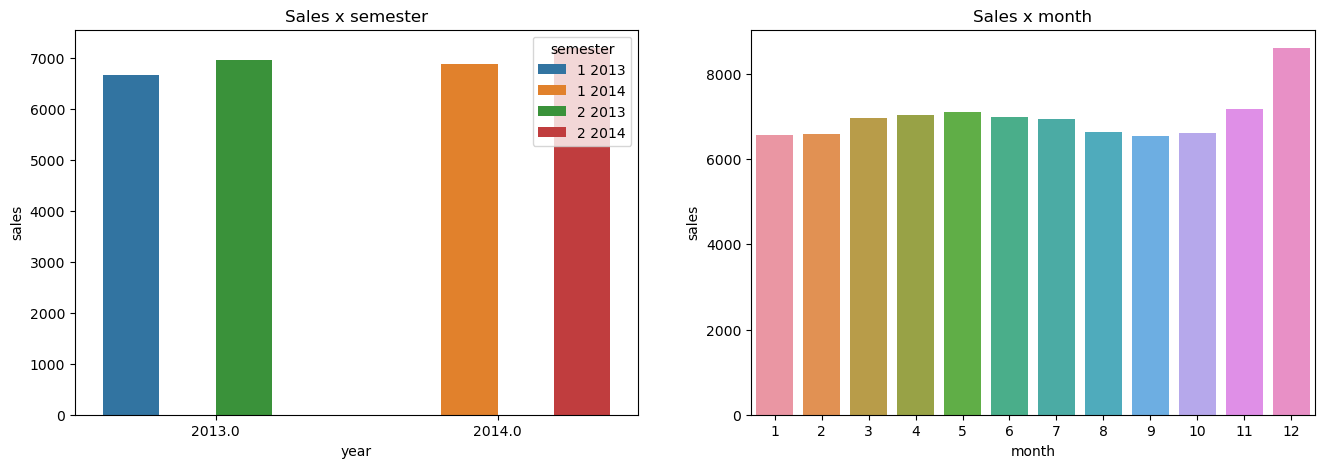

In [46]:
plt.rcParams["figure.figsize"] = (16,5)
plt.subplot( 1, 2, 1 )
plt.title('Sales x semester')
year_sales = df5[['year','month','sales']]
year_sales['semester'] = year_sales['month'].apply(lambda x: 1 if x <= 6 else 2)
year_sales['semester'] = year_sales.apply(lambda x: str(x['semester']) + " " + str(x['year']), axis = 1)
year_sales = year_sales.groupby('semester').mean().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'semester', data = year_sales[year_sales['year'] != 2015] )

plt.subplot( 1, 2, 2 )
plt.title('Sales x month')
year_sales = df5[['year','month','sales']]
year_sales = year_sales.groupby('month').mean().reset_index()
sns.barplot(x = 'month', y = 'sales', data = year_sales[year_sales['year'] != 2015] )

**Hypotesis 10:**  Stores should sell more after the 10th of each month\
**TRUE** Sales increase from the 11th of each month, but decrease again from the 19th-20th

<AxesSubplot:title={'center':'Sales x days'}, xlabel='day', ylabel='sales'>

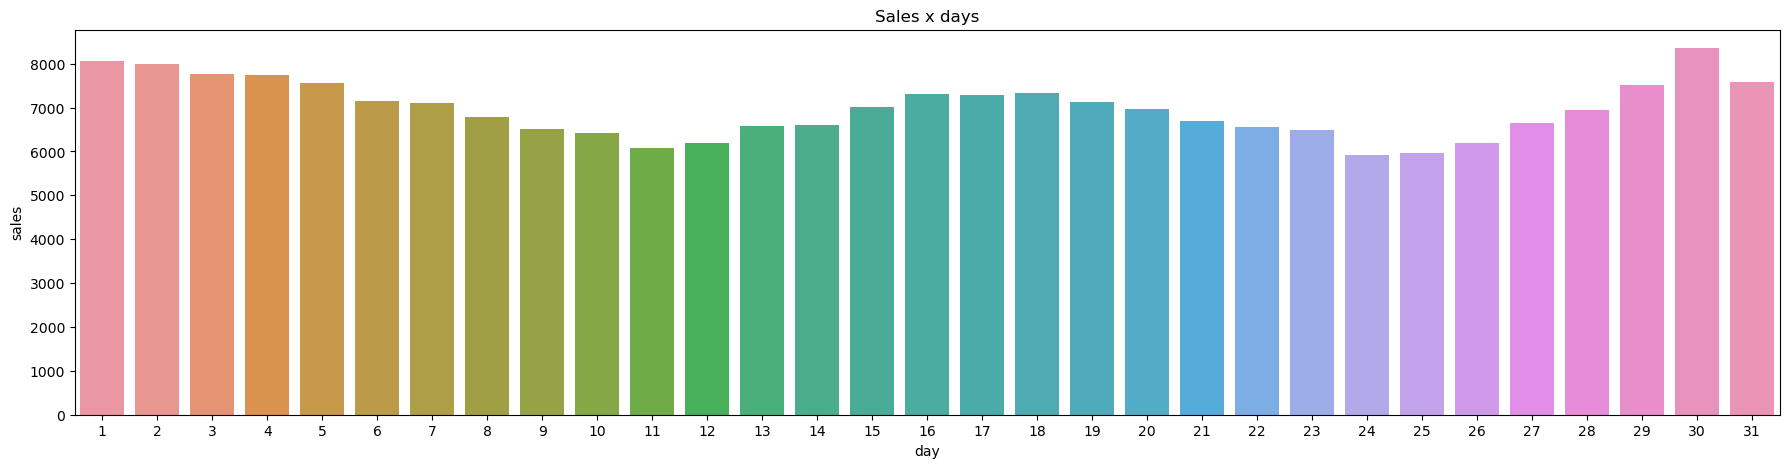

In [47]:
plt.rcParams["figure.figsize"] = (22,5)
plt.title('Sales x days')
daily_sales = df5[['day', 'sales']].groupby('day').mean().reset_index()
sns.barplot(x = 'day', y = 'sales', data = daily_sales)

**HYPOTESIS 11:**  Stores should sell less on weekends\
**TRUE** Total sales are lower on Saturdays and much lower on Sundays (as many stores do not open on Sundays). Considering the average, sales on Sunday are high, this may be due to the fact that stores open on Sunday only for a special occasion (holiday, promotion, etc.)

<AxesSubplot:title={'center':'total sales x week days'}, xlabel='week_day', ylabel='sales'>

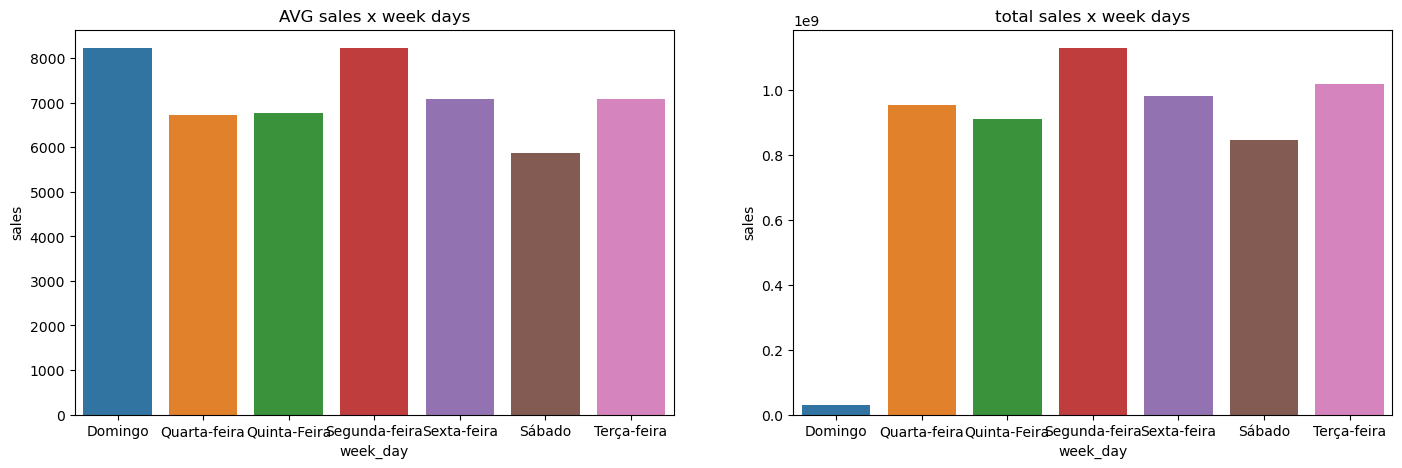

In [48]:
plt.rcParams["figure.figsize"] = (17,5)
plt.subplot(1, 2, 1)
plt.title('AVG sales x week days')
sales_weekends = df5[['date','sales']]
sales_weekends['week_day'] = sales_weekends['date'].apply(lambda x: x.weekday())
dias = ['Segunda-feira','Terça-feira','Quarta-feira','Quinta-Feira','Sexta-feira','Sábado','Domingo']
sales_weekends['week_day'] = sales_weekends['week_day'].apply(lambda x: dias[x])
sales_weekends = sales_weekends.groupby('week_day').mean().reset_index()
sns.barplot(x = 'week_day', y = 'sales', data = sales_weekends)

plt.subplot(1, 2, 2)
plt.title('total sales x week days')
sales_weekends = df5[['date','sales']]
sales_weekends['week_day'] = sales_weekends['date'].apply(lambda x: x.weekday())
dias = ['Segunda-feira','Terça-feira','Quarta-feira','Quinta-Feira','Sexta-feira','Sábado','Domingo']
sales_weekends['week_day'] = sales_weekends['week_day'].apply(lambda x: dias[x])
sales_weekends = sales_weekends.groupby('week_day').sum().reset_index()
sns.barplot(x = 'week_day', y = 'sales', data = sales_weekends)

**Hypotesis 12:**  Stores should sell less during school holidays\
**FALSE** Stores sell more during school holidays

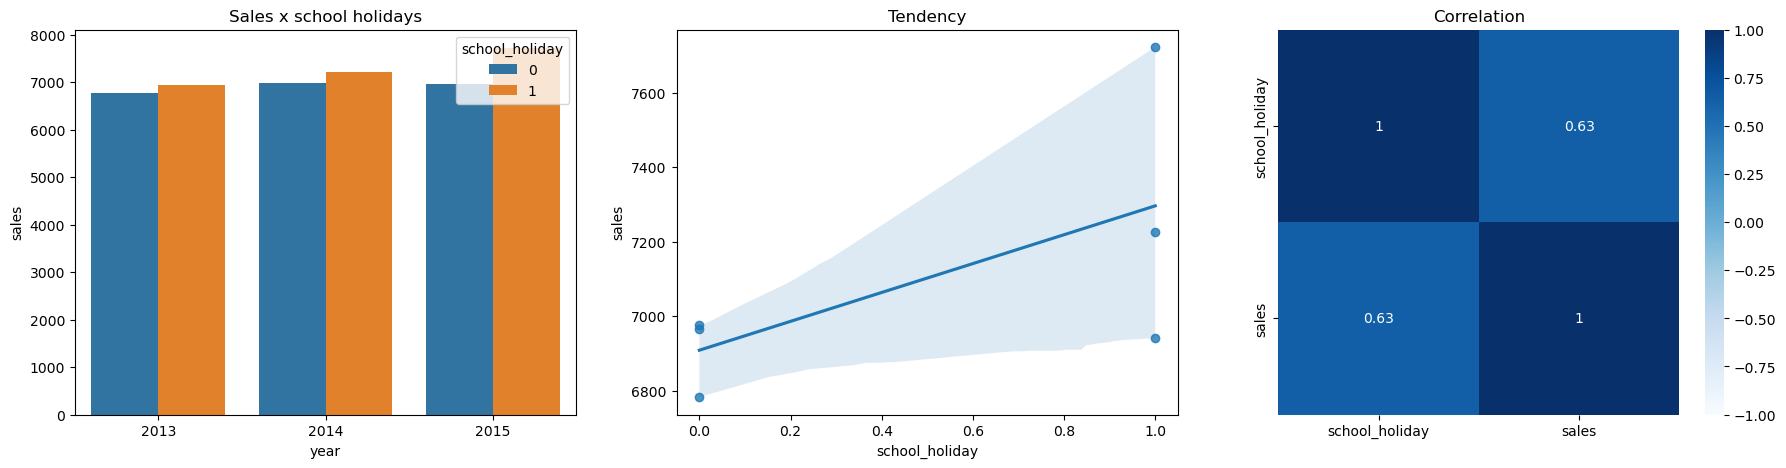

In [49]:
plt.rcParams["figure.figsize"] = (22,5)
plt.subplot(1, 3, 1)
plt.title('Sales x school holidays')
school_holiday = df5[['sales', 'year', 'school_holiday']].groupby(['school_holiday','year']).mean().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'school_holiday', data = school_holiday)
plt.subplot(1, 3, 2)
plt.title('Tendency')
sns.regplot(x = 'school_holiday', y = 'sales', data = school_holiday)

plt.subplot(1, 3, 3)
plt.title('Correlation')
sns.regplot(x = 'school_holiday', y = 'sales', data = school_holiday)

sns.heatmap( school_holiday[['school_holiday','sales']].corr( method='pearson' ), annot=True,cmap = 'Blues', vmin = -1, vmax = 1  );

#### 4.2.1. Summary of Hypotheses

In [50]:
hip_conclusion = pd.DataFrame( [ ['H1',  	    'True',     	'Alta'],
                                ['H2',  	    'False',    	'Baixa'],
                                ['H3',  	    'False',    	'Média'],
                                ['H4',  	    'False',    	'Baixa'],
                                ['H5',  	    'False',    	'Média'],
                                ['H6',  	    'False',    	'Baixa'],
                                ['H7',  	    'True',	        'Média'],
                                ['H8',  	    'True', 	    'Média'],
                                ['H9',  	    'True', 	    'Alta' ],
                                ['H10', 	    'True',      	'Alta' ],
                                ['H11', 	    'True', 	    'Alta' ],
                                ['H12', 	    'False',    	'Média']],
                                columns = ['Hypotesis',	'Conclusion',	'Relevance'])
hip_conclusion


,Hypotesis,Conclusion,Relevance
0,H1,True,Alta
1,H2,False,Baixa
2,H3,False,Média
3,H4,False,Baixa
4,H5,False,Média
5,H6,False,Baixa
6,H7,True,Média
7,H8,True,Média
8,H9,True,Alta
9,H10,True,Alta


### 4.3. Multivariate analysis

#### 4.3.1. Numerical Attributes

<AxesSubplot:title={'center':'Correlation Heatmap'}>

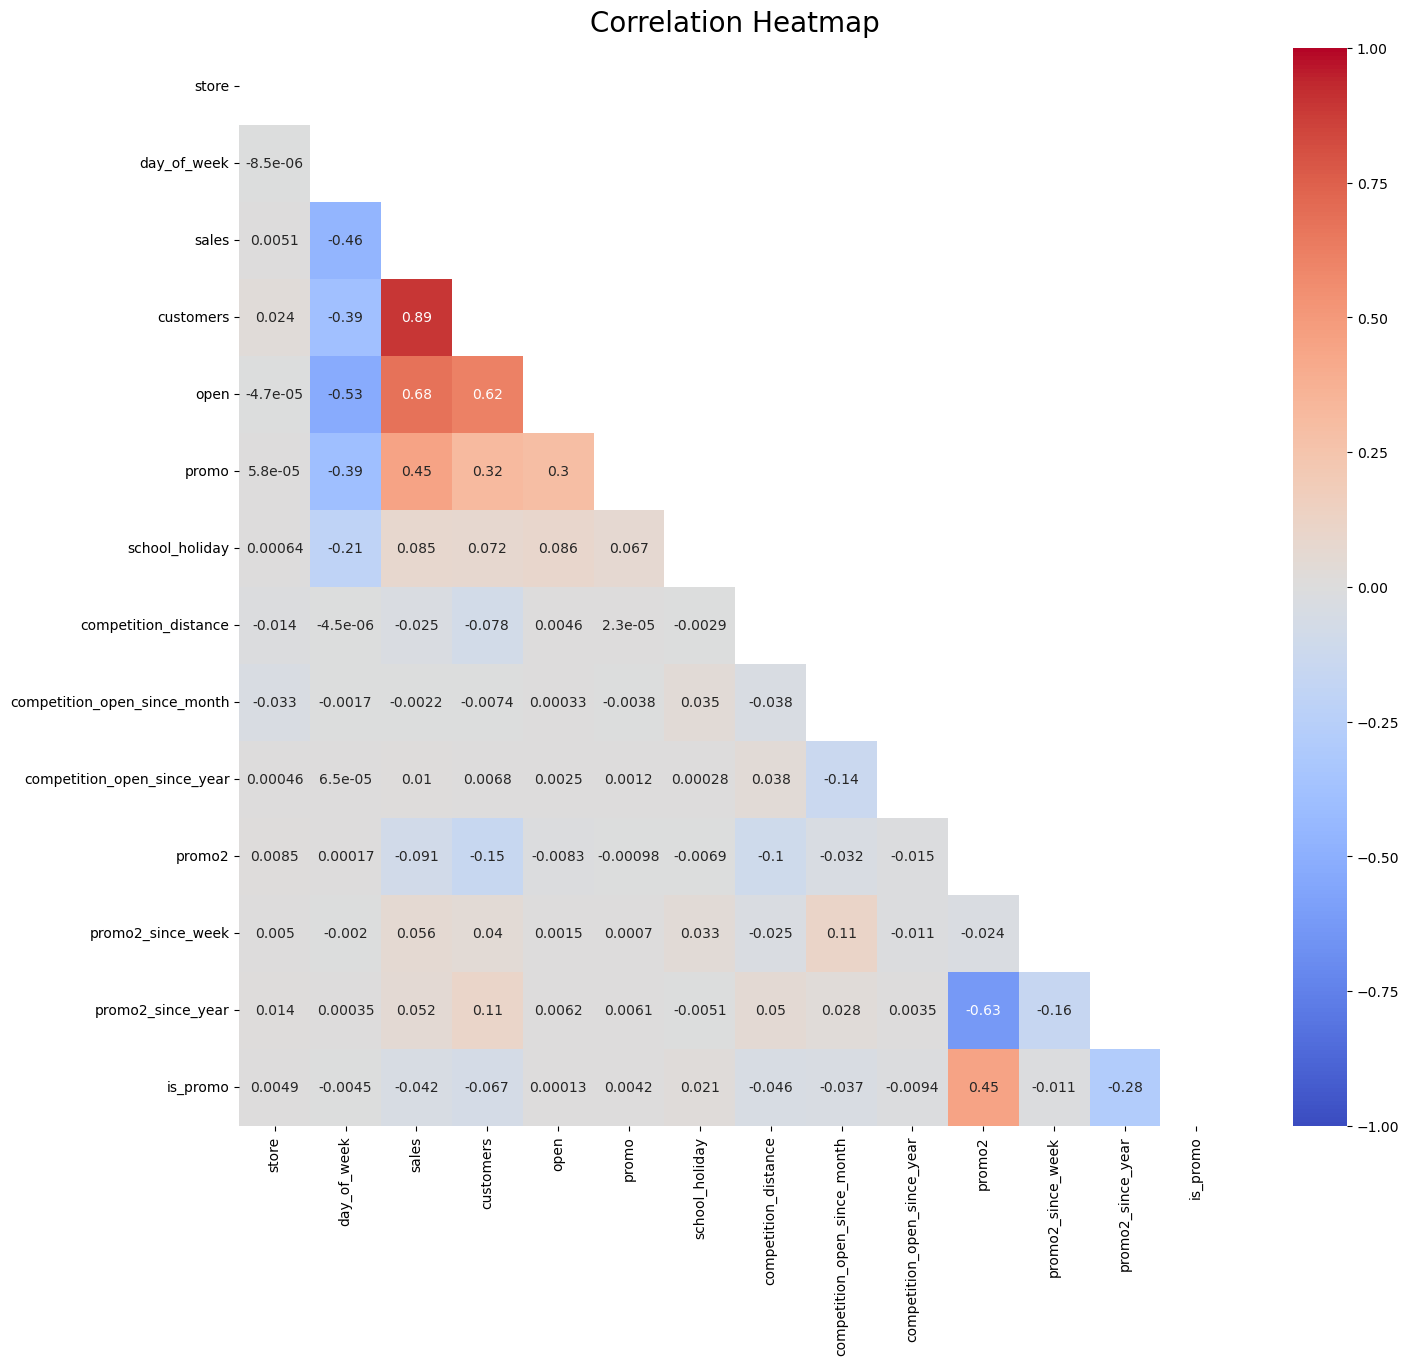

In [51]:
plt.figure(figsize=(16, 14) )
plt.title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);
correlation = num_attributes.corr(method = 'pearson')
matrix = np.triu(correlation)
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm', mask=matrix)

#### 4.3.2. Categorical Attributes

<AxesSubplot:title={'center':'Correlation Heatmap'}>

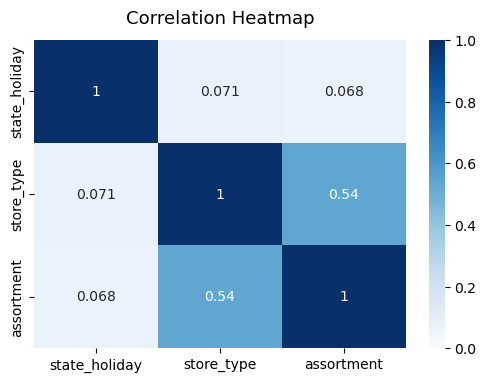

In [52]:
categorical_attributes = df5.select_dtypes( include = 'object')


# Calculate Cramer V
a1 = cramer_v(categorical_attributes['state_holiday'],categorical_attributes['state_holiday'])
a2 = cramer_v(categorical_attributes['state_holiday'],categorical_attributes['store_type'])
a3 = cramer_v(categorical_attributes['state_holiday'],categorical_attributes['assortment'])

a4 = cramer_v(categorical_attributes['store_type'],categorical_attributes['state_holiday'])
a5 = cramer_v(categorical_attributes['store_type'],categorical_attributes['store_type'])
a6 = cramer_v(categorical_attributes['store_type'],categorical_attributes['assortment'])

a7 = cramer_v(categorical_attributes['assortment'],categorical_attributes['state_holiday'])
a8 = cramer_v(categorical_attributes['assortment'],categorical_attributes['store_type'])
a9 = cramer_v(categorical_attributes['assortment'],categorical_attributes['assortment'])

# Categorical correlation dataset
cat_corr = pd.DataFrame( {'state_holiday' : [a1, a2, a3],
                          'store_type' : [a4, a5, a6], 
                          'assortment' : [a7, a8, a9]}  )
cat_corr = cat_corr.set_index(cat_corr.columns)

plt.figure(figsize=(6, 4) )
plt.title('Correlation Heatmap', fontdict={'fontsize':13}, pad=12);
sns.heatmap(cat_corr, vmin=0, vmax=1, annot=True, cmap='Blues')

In [53]:
cat_corr

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


# 5.0. Data Preparation

In [54]:
df6 = df5.copy()
numerical = df6.select_dtypes(include = ['int32', 'int64', 'float64'])
categorical = df6.select_dtypes(exclude = ['int32', 'int64', 'float64'])

In [55]:
# Cyclical
#'month'
#'day'
#'week_of_year'
#'day_of_week'

# Non cyclical
#'competition_distance'
#'year'
#'competition_time_month'
#'promo_time_week'

# Categorical
#state_holiday'
#'store_type'
#'assortment'

### 5.1. Normalization

Nothing to normalize (no normal distribution)

### 5.2. Rescaling

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition_distance
df6['competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))
# Competition_time_mont
df6['competition_time_month'] = rs.fit_transform(df6[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))
# Promo_time_week
df6['promo_time_week'] = mms.fit_transform(df6[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl','wb'))
# Year
df6['year'] = mms.fit_transform(df6[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))


### 5.3. Transformation

#### 5.3.1. Encoding

In [56]:
#state_holiday (one hot encoding)
df6 = pd.get_dummies(df6, prefix = ['state_holiday'], columns = ['state_holiday'])

#stote type (label encoding)
le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))
#assortment
assortment_dict = {'basic':1,'extra':2,'extended':3}

#### 5.3.1. Encoding
df6['assortment'] = df6['assortment'].map(assortment_dict)

#### 5.3.2. Response Variable Transformation

In [57]:
# Logarithm transformation
df6['sales'] = np.log1p(df6['sales'])

#### 5.3.3. Nature transformation

In [58]:
# day_of_week
df6['day_of_week_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 7 )))
df6['day_of_week_cos'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 7 )))

# month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 12 )))
df6['month_cos'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 12 )))

# day 
df6['day_sin'] = df6['day'].apply(lambda x: np.sin( x * ( 2. * np.pi / 30 )))
df6['day_cos'] = df6['day'].apply(lambda x: np.sin( x * ( 2. * np.pi / 30 )))

# week of year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi / 52 )))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi / 52 )))

# 6.0. Feature Selection

In [59]:
df7 = df6.copy()

In [60]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df7 = df7.drop(cols_drop, axis = 1)

### 6.1. Split dataframe into training and test

In [61]:
# Test data: 6 last weeks
df7[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6 * 7)

Timestamp('2015-06-19 00:00:00')

In [62]:
#Train dataset
X_train = df7[df7['date'] < '2015-06-19']
y_train = X_train['sales'].values.ravel()

#Test dataset
X_test = df7[df7['date'] >= '2015-06-19']
y_test = X_test['sales']
X_test = X_test.drop(['date','sales'], axis = 1)

### 6.2. Boruta as Feature Selector

In [63]:
# Train and test datasets for Boruta
X_train_n = X_train.drop(['date','sales'], axis = 1).values
y_train_n = X_train['sales'].values.ravel()

rf = RandomForestRegressor(n_jobs = -1)

# define Boruta
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	1
Reject

In [64]:
selected_cols = boruta.support_.tolist()

# Best features
X_train_fs = X_train.drop(['date','sales'], axis = 1)
selected_cols_boruta = X_train_fs.iloc[:,selected_cols].columns

# not selected Boruta
not_selected_cols_boruta = list(np.setdiff1d(X_train_fs.columns, selected_cols_boruta))

### 6.3. Manual Feature Selection

In [65]:
# Selecting Features according to Boruta and Hypotesis conclusions (section 4.2)
final_features = ['day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'month_sin', 'week_of_year_cos', 'week_of_year_sin', 
                  'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 
                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_sin','date','sales']
boruta_full_df = df7[final_features]


# 7.0. Machine Learning Modelling

In [66]:
df8 = df7.copy() 
X_train_cv = boruta_full_df[boruta_full_df['date'] < '2015-06-19']
X_train = X_train[final_features[:-2]]
X_test = X_test[final_features[:-2]]

### 7.1. Average Model

In [67]:
X_test_avg = X_test.copy()
X_test_avg['sales'] = y_test.copy()

# Prediction
predictions = X_test_avg[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
predictions = pd.merge(X_test_avg, predictions, how = 'left', on = 'store')
yhat_baseline = predictions['predictions']

#Performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 7.2. Linear Regression Model

In [68]:
# model
lr = LinearRegression().fit(X_train, y_train)

# Prediction
yhat_lr = lr.predict(X_test)

# Performance
lr_result = ml_error('Linear Regression',  np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1886.845859,0.296328,2694.659958


#### 7.2.1. Linear Regression Model - Cross Validation


In [69]:
lr_result_cv = cross_validation( X_train_cv, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.0 +/- 280.91,0.3 +/- 0.01,2955.05 +/- 426.56


### 7.3. Linear Regression Regularized Model - Lasso

In [70]:
# model
lasso = Lasso(alpha = 0.001).fit(X_train, y_train)

# Prediction
yhat_lasso = lasso.predict(X_test)

# Performance
lasso_result = ml_error('Linear Regression - Lasso',  np.expm1(y_test), np.expm1(yhat_lasso))
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1892.072276,0.293573,2716.781602


#### 7.3.1. Lasso - Cross Validation

In [71]:
lasso_result_cv = cross_validation( X_train_cv, 5, 'Lasso', lasso, verbose=False )
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2090.34 +/- 307.94,0.3 +/- 0.01,2995.12 +/- 458.89


### 7.4. Random Forest Regressor

In [72]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(X_train, y_train)

# Prediction
yhat_rf = rf.predict(X_test)

# Performance
rf_result = ml_error('Random Forest',  np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,866.464523,0.133976,1211.588602


#### 7.4.1. Random Forest Cross Validation

In [73]:
rf_result_cv = cross_validation( X_train_cv, 5, 'Random Forest Regressor', rf,verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1104.87 +/- 209.75,0.16 +/- 0.03,1530.38 +/- 273.38


### 7.5. XGBoost Regressor

In [74]:
# model
model_xgb = xgb.XGBRegressor(n_jobs = -1).fit(X_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(X_test)

# Performance
xgb_result = ml_error('XGBoost',  np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,1019.965223,0.154997,1429.520839


#### 7.5.1. XGBoost Cross Validation

In [75]:
xgb_result_cv = cross_validation( X_train_cv, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1179.33 +/- 111.96,0.17 +/- 0.01,1639.3 +/- 148.34


### 7.6.Comparing Model's Performance

In [76]:
modelling_result = pd.concat( [baseline_result, lr_result, lasso_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' ).set_index('Model Name')

,MAE,MAPE,RMSE
Model Name,,,
Random Forest,866.464523,0.133976,1211.588602
XGBoost,1019.965223,0.154997,1429.520839
Average Model,1354.800353,0.206400,1835.135542
Linear Regression,1886.845859,0.296328,2694.659958
Linear Regression - Lasso,1892.072276,0.293573,2716.781602


In [77]:
cv_result = pd.concat( [lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv] ).set_index('Model Name')
cv_result
# Selected Model: XGBoost

,MAE CV,MAPE CV,RMSE CV
Model Name,,,
Linear Regression,2079.0 +/- 280.91,0.3 +/- 0.01,2955.05 +/- 426.56
Lasso,2090.34 +/- 307.94,0.3 +/- 0.01,2995.12 +/- 458.89
Random Forest Regressor,1104.87 +/- 209.75,0.16 +/- 0.03,1530.38 +/- 273.38
XGBoost Regressor,1179.33 +/- 111.96,0.17 +/- 0.01,1639.3 +/- 148.34


# 8.0. Hyperparameter Fine Tuning

### 8.1. Random Search

In [78]:
#Train dataset
X_train = boruta_full_df[boruta_full_df['date'] < '2015-06-19']
y_train = X_train['sales'].values

#Test dataset
X_test = boruta_full_df[boruta_full_df['date'] >= '2015-06-19']
y_test = X_test['sales'].values
X_train = X_train.drop(['date','sales'], axis = 1)
X_test = X_test.drop(['date','sales'], axis = 1)

In [79]:
param = {
    'n_estimators' : [1500, 1700, 2500, 3000, 3500],
    'eta' : [0.01, 0.03],
    'max_depth' : [3, 5, 9],
    'subsample' : [0.1, 0.5, 0.7],
    'colsample_bytree' : [0.3, 0.7, 0.9],
    'min_child_weight' : [3, 8, 15]
    }
max_eval = 5

In [80]:
final_result = []
pars = []
for i in range(max_eval):

    # Choose values for parameters randomly
    hp = { k : random.sample(v,1)[0] for k, v in param.items() }      
    print(hp)
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'], 
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'])

    # Performance
    xgb_result = cross_validation(X_train_cv, 5, 'XGBoost Regressor', model_xgb, verbose = False)
    final_result.append(xgb_result)
    pars.append(hp)
final_result = pd.concat(final_result)
final_result['params'] = pars
final_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV,params
0,XGBoost Regressor,1184.2 +/- 105.91,0.17 +/- 0.01,1664.01 +/- 143.03,"{'n_estimators': 1500, 'eta': 0.03, 'max_depth..."
0,XGBoost Regressor,1041.17 +/- 113.12,0.15 +/- 0.02,1427.81 +/- 147.68,"{'n_estimators': 3500, 'eta': 0.03, 'max_depth..."
0,XGBoost Regressor,1073.59 +/- 100.35,0.15 +/- 0.01,1489.15 +/- 136.22,"{'n_estimators': 3500, 'eta': 0.03, 'max_depth..."
0,XGBoost Regressor,1551.32 +/- 152.73,0.22 +/- 0.01,2215.74 +/- 212.47,"{'n_estimators': 1500, 'eta': 0.01, 'max_depth..."
0,XGBoost Regressor,1507.09 +/- 144.8,0.21 +/- 0.01,2148.16 +/- 198.15,"{'n_estimators': 1700, 'eta': 0.01, 'max_depth..."


### 8.2. Final Model

In [81]:
param_tunned = {
    'n_estimators' : 3000,
    'eta' : 0.03,
    'max_depth' : 5,
    'subsample' : 0.7,
    'colsample_bytree' : 0.7,
    'min_child_weight' : 3 
    }

In [82]:
# model
model_xgb_tunned = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators = param_tunned['n_estimators'],
                            eta = param_tunned['eta'],
                            max_depth = param_tunned['max_depth'], 
                            subsample = param_tunned['subsample'],
                            colsample_bytree = param_tunned['colsample_bytree'],
                            min_child_weight = param_tunned['min_child_weight']).fit(X_train, y_train)

# Prediction
yhat_xgb_tunned = model_xgb_tunned.predict(X_test)

# Performance
xgb_result_tunned = ml_error('XGBoost Regresor', np.expm1(y_test), np.expm1(yhat_xgb_tunned))

# salvar modelo
import pickle
with open('model/xgbtunned.pkl', 'wb') as file:
    pickle.dump(model_xgb_tunned, file)


mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tunned ) )
print("MPE: ",mpe)
xgb_result_tunned

MPE:  -0.013689191963552314


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regresor,949.881428,0.143602,1336.919406


# 9.0. Error interpretation

In [84]:
# Load model
with open('model/xgbtunned.pkl', 'rb') as f:
    tunned_xgb = pickle.load(f)
yhat_xgb_tunned = tunned_xgb.predict(X_test)

In [85]:
df9 = boruta_full_df[boruta_full_df['date'] >= '2015-06-19']

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tunned)

### 9.1. Business Performance

In [86]:
# sum of predictions by store
predictinons_by_store = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()
# MAPE
calc_mape = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})
# Merge
merged_df = pd.merge( predictinons_by_store, calc_mape, how='inner', on='store' )
# MAE
merged_df['MAE'] = merged_df['predictions'] * merged_df['MAPE']
# Scenarios
merged_df['worst_scenario'] = merged_df['predictions'] - merged_df['MAE']
merged_df['best_scenario'] = merged_df['predictions'] + merged_df['MAE']
# order columns
merged_df = merged_df[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]
merged_df.head(5)


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,164545.937500,150086.630693,179005.244307,14459.306807,0.087874
1,2,178759.593750,151883.562246,205635.625254,26876.031504,0.150347
2,3,266517.187500,231827.113906,301207.261094,34690.073594,0.130161
3,4,340026.468750,303667.238829,376385.698671,36359.229921,0.106931
4,5,170492.609375,132908.074491,208077.144259,37584.534884,0.220447


In [87]:
merged_df.sort_values('MAPE', ascending = False).head(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106183.265625,43464.254510,168902.276740,62719.011115,0.590668
908,909,214237.328125,93952.768429,334521.887821,120284.559696,0.561455
875,876,199810.296875,105932.052658,293688.541092,93878.244217,0.469837
606,607,140673.734375,91219.855559,190127.613191,49453.878816,0.351550
785,786,131913.234375,85826.749588,177999.719162,46086.484787,0.349370


<AxesSubplot:title={'center':'Mape distribution'}, xlabel='store', ylabel='MAPE'>

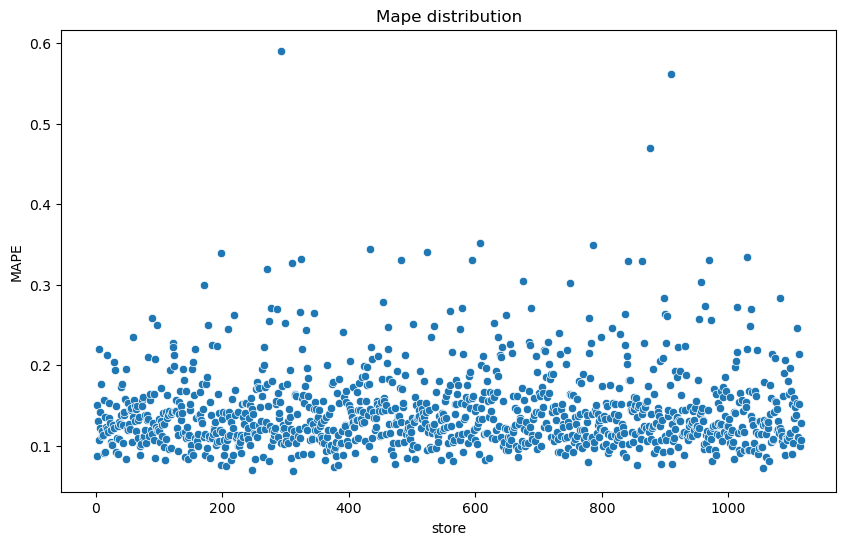

In [88]:
plt.subplots(figsize=(10, 6))
plt.title('Mape distribution')
sns.scatterplot(x = 'store', y = 'MAPE', data = merged_df)

### 9.2. Total Performance

In [89]:
total_performance = pd.DataFrame(merged_df[['predictions', 'worst_scenario','best_scenario']].sum()).reset_index().rename(columns={'index':'Scenario',0:'Values'})
total_performance['Values'] = total_performance['Values'].map('${:,.2f}'.format)
total_performance

,Scenario,Values
0,predictions,"$283,742,272.00"
1,worst_scenario,"$244,033,471.48"
2,best_scenario,"$323,451,121.16"


### 9.3. Machine Learning Performance

<AxesSubplot:title={'center':'Error distribution'}, xlabel='predictions', ylabel='error'>

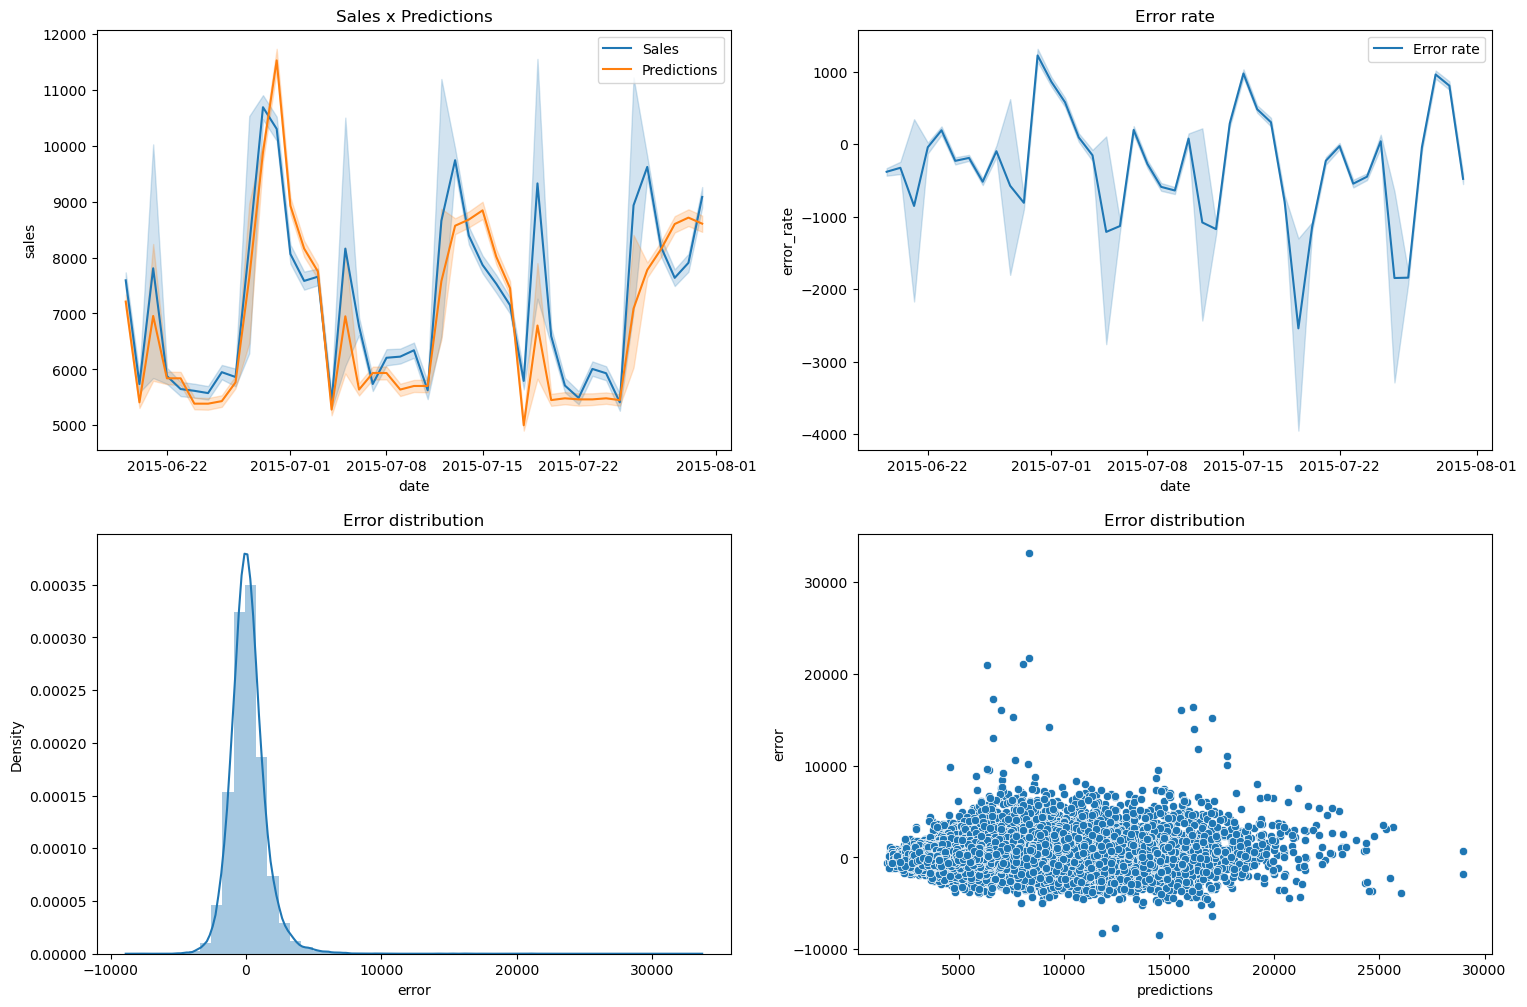

In [90]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] - df9['sales']

plt.subplots(figsize=(18, 12))
plt.subplot(2, 2, 1)
plt.title('Sales x Predictions')
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'Sales')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'Predictions')

plt.subplot(2, 2, 2)
plt.title('Error rate')
sns.lineplot(x = 'date', y = 'error_rate', data = df9, label = 'Error rate')

plt.subplot(2, 2, 3)
plt.title('Error distribution')
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
plt.title('Error distribution')
sns.scatterplot(x = df9['predictions'], y = df9['error'])


# 10.0. Model Deployment

In [92]:
# Load model
with open('xgboost_tunned.pkl', 'rb') as f:
    tunned_xgb = pickle.load(f)
model = tunned_xgb.predict(X_test)

### 10.1. Rossmann Class

In [91]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = 'C:/Users/igor/Documents/repos/ds_em_producao/Project/'
        self.competition_distance_scaler =  pickle.load(open( self.home_path  +  'parameter/competition_distance_scaler.pkl',          'rb'))
        self.competition_time_month_scaler =       pickle.load(open( self.home_path  +  'parameter/competition_time_month_scaler.pkl',        'rb'))
        self.promo_time_week_scaler =              pickle.load(open( self.home_path  +  'parameter/promo_time_week_scaler.pkl',               'rb'))
        self.year_scaler =                  pickle.load(open( self.home_path  +  'parameter/year_scaler.pkl',                          'rb'))
        self.store_type_scaler =            pickle.load(open( self.home_path  +  'parameter/store_type_scaler.pkl',                    'rb'))
    
    def data_cleaning(self, df1):
        # Rename columns
        old_cols = ['Store', 'DayOfWeek', 'Date','Open','Promo', 'StateHoliday', 'SchoolHoliday',
                              'StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth',
                              'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
                              
        snakecase = lambda x: inflection.underscore( x )
        new_cols = list ( map( snakecase, old_cols))
        # rename
        df1.columns = new_cols

        # 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        # 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].fillna(200000)
        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) == True else x['competition_open_since_month'], axis = 1)
        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) == True else x['competition_open_since_year'], axis = 1)
        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) == True else x['promo2_since_week'], axis = 1)
        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) == True else x['promo2_since_year'], axis = 1)
        # promo_interval
        months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.apply(lambda x: months[x])
        df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)
        ### 1.6. Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1

    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)
        # assortment
        dict_assort = {'a': 'basic', 'b': 'extra','c': 'extended'}
        df2['assortment'] = df2['assortment'].apply(lambda x: dict_assort[x])
        # state holiday
        dict_holiday = {'0': 'regular_day', 'a':'public_holiday','b': 'easter','c': 'christmas'}
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: dict_holiday[x])
        ### 3.1. Filtragem das linhas
        df2 = df2[df2['open'] != 0 ]
        ### 3.2 Seleção das colunas
        cols_drop = ["open","promo_interval","month_map"]
        df2 = df2.drop(cols_drop, axis = 1)

        return df2

    def data_preparation(self, df6):
        numerical = df6.select_dtypes(include = ['int32', 'int64', 'float64'])
        categorical = df6.select_dtypes(exclude = ['int32', 'int64', 'float64'])
        ### 5.2. Rescaling
        #competition_distance
        df6['competition_distance'] = self.competition_distance_scaler.transform(df6[['competition_distance']].values)
        # Competition_time_mont
        df6['competition_time_month'] = self.competition_time_month_scaler.transform(df6[['competition_time_month']].values)
        # Promo_time_week
        df6['promo_time_week'] = self.promo_time_week_scaler.transform(df6[['promo_time_week']].values)
        # Year
        df6['year'] = self.year_scaler.transform(df6[['year']].values)
        #### 5.3.1. Encoding
        #state_holiday (one hot encoding)
        df6 = pd.get_dummies(df6, prefix = ['state_holiday'], columns = ['state_holiday'])
        #stote type (label encoding)
        df6['store_type'] = self.store_type_scaler.transform(df6['store_type'])
        #assortment
        assortment_dict = {'basic':1,'extra':2,'extended':3}
        #### 5.3.1. Encoding
        df6['assortment'] = df6['assortment'].map(assortment_dict)
        #### 5.3.3. Nature transformation
        # day_of_week
        df6['day_of_week_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 7 )))
        df6['day_of_week_cos'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 7 )))
        # month
        df6['month_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 12 )))
        df6['month_cos'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 12 )))
        # day 
        df6['day_sin'] = df6['day'].apply(lambda x: np.sin( x * ( 2. * np.pi / 30 )))
        df6['day_cos'] = df6['day'].apply(lambda x: np.sin( x * ( 2. * np.pi / 30 )))
        # week of year
        df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi / 52 )))
        df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi / 52 )))

        final_features = ['day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'month_sin', 'week_of_year_cos', 'week_of_year_sin', 
                  'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 
                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_sin']

        return df6[final_features]
    
    def get_prediction( self, model, original_data, test_data):
        pred = model.predict(test_data)
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient = 'records', date_format = 'iso')

### 10.2. API Handler

In [99]:
from flask import Flask, request, Response
import pickle
from webapp.rossmann.Rossmann import Rossmann
import pandas as pd


# loading model
model = pickle.load(open('C:/Users/igor/Documents/repos/ds_em_producao/Project/model/xgbtunned.pkl','rb'))

# Initiate API
app = Flask(__name__)

@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ):
            test_raw = pd.DataFrame(test_json, index=[0]) # unique example
        else: 
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys()) # multiple example
        
        # Instantiate Rosmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # Feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data preparation
        df3 = pipeline.data_preparation ( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)

        return df_response


    else:
        return Response ('{}', status = 200, mimetype = 'application/json')
    


if __name__ == '__main__':
    app.run( '10.0.0.175')



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://10.0.0.175:5000/ (Press CTRL+C to quit)


### 10.1. API Tester

In [94]:
import pandas as pd
import requests
# Loading dataset
test_data = pd.read_csv('data/test.csv')
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge test dataset + store
df_test = pd.merge( test_data, df_store_raw, how = 'left', on = 'Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin([20,23,22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
# drop ID
df_test = df_test.drop('Id', axis = 1 )

# convert Dataframe to json
import json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [100]:
# API Call
#url =  'https://rossmann-model-new-app.herokuapp.com/rossmann/predict'  
url = 'http://10.0.0.175:5000/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [101]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

d2 = d1[['store','prediction']].groupby('store').sum().reset_index()
for i in range(len(d2)):
    print("Store number {} will sell ${:,.2f} in the next 6 weeks".format(d2.loc[i, 'store'], d2.loc[i,'prediction']))

Store number 20 will sell $308,938.79 in the next 6 weeks
Store number 22 will sell $188,174.05 in the next 6 weeks
Store number 23 will sell $233,124.20 in the next 6 weeks
